# Classification of Parkinson disease patients in medication discontinuation 

In [1]:
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score, cohen_kappa_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import seaborn as sn

# Parameters for filepaths, datasets, experiments and models

In [2]:
seed=1082141
random.seed(seed)
np.random.seed(seed)

# path to directory with descriptive statistic data of subject recordings
dataset_dir = '../data/interim/'

# path to file with preprocessed bandpower features
filepath_bandpower = '../data/bandpower/Cz_Fz_Pz_Oz_bandPowers.csv'

# path to directory with dataset participants metadata
partic_dt_filepath = '/m/eeg_dataset/ds003509-download/participants.tsv'

# if "debug == True" include extensive print/outputs to notebook cells 
debug = True

In [3]:
# define explored params

n_folds = 5
search_n_iter = 50

exprs_datasets_explored = ['dataset_full', 'dataset_filtered_features']

# param_grid_logregl2
param_range = search_n_iter
penalty = ['l2']
C_range = np.logspace(-5, 15, param_range, base=2)
param_grid_logregl2 = dict(penalty=penalty, C=C_range)

# param_grid_svm
param_range = search_n_iter
C_range = np.logspace(-5, 15, param_range, base=2)
gamma = np.logspace(-9, 3, param_range, base=2)
param_grid_svm = dict(C=C_range, gamma=gamma)

# param_grid_knn
knn_param_range = 40
knn_max_n = 40
K_range = [round(random.random()*knn_max_n + 1) for i in range(knn_param_range)]
param_grid_knn = dict(n_neighbors=K_range)

# param_grid_decisiontree
param_range = search_n_iter
ccp_alpha_range = [0.0] + [(random.random()*0.04) for i in range(param_range-1)]
param_grid_decisiontree = dict(ccp_alpha=ccp_alpha_range)

# param_grid_randomforest
n_estimators_range = [10, 100, 1000]
max_features_range = [5, 10, 22]
param_grid_randomforest = dict(n_estimators=n_estimators_range, max_features=max_features_range)

expr_params = [{
        'model_name': 'LogisticRegression',
        'model': LogisticRegression(),
        'param_grid': {},
        'search_type': 'grid',
    },{
        'model_name': 'LogisticRegression_L2',
        'model': LogisticRegression(),
        'param_grid': param_grid_logregl2,
        'search_type': 'grid',
    },{
        'model_name': 'SVM kernel linear',
        'model': svm.SVC(kernel='linear', max_iter=10000),
        'param_grid': param_grid_svm,
        'search_type': 'rand',
        'search_n_iter': search_n_iter,
    },{
        'model_name': 'SVM kernel rbf',
        'model': svm.SVC(kernel='rbf', max_iter=10000),
        'param_grid': param_grid_svm,
        'search_type': 'rand',
        'search_n_iter': search_n_iter,
    },{
        'model_name': 'KNN',
        'model': KNeighborsClassifier(),
        'param_grid': param_grid_knn,
        'search_type': 'rand',
        'search_n_iter': knn_param_range,
    },{
        'model_name': 'Decision Tree',
        'model': DecisionTreeClassifier(),
        'param_grid': param_grid_decisiontree,
        'search_type': 'rand',
        'search_n_iter': search_n_iter,
    },{
        'model_name': 'Random Forest',
        'model': RandomForestClassifier(),
        'param_grid': param_grid_randomforest,
        'search_type': 'grid',
    },
]

_expr_params = expr_params
expr_params = []
for i in range(len(_expr_params)):
    for expr_dataset in exprs_datasets_explored:
        aux_expr = _expr_params[i].copy()
        aux_expr['expr_dataset'] = expr_dataset
        expr_params.append(aux_expr)

pd.DataFrame.from_records(expr_params)

,model_name,model,param_grid,search_type,expr_dataset,search_n_iter
0,LogisticRegression,LogisticRegression(),{},grid,dataset_full,NaN
1,LogisticRegression,LogisticRegression(),{},grid,dataset_filtered_features,NaN
2,LogisticRegression_L2,LogisticRegression(),"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...",grid,dataset_full,NaN
3,LogisticRegression_L2,LogisticRegression(),"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...",grid,dataset_filtered_features,NaN
4,SVM kernel linear,"SVC(kernel='linear', max_iter=10000)","{'C': [0.03125, 0.04146860325085487, 0.0550286...",rand,dataset_full,50.0
5,SVM kernel linear,"SVC(kernel='linear', max_iter=10000)","{'C': [0.03125, 0.04146860325085487, 0.0550286...",rand,dataset_filtered_features,50.0
6,SVM kernel rbf,SVC(max_iter=10000),"{'C': [0.03125, 0.04146860325085487, 0.0550286...",rand,dataset_full,50.0
7,SVM kernel rbf,SVC(max_iter=10000),"{'C': [0.03125, 0.04146860325085487, 0.0550286...",rand,dataset_filtered_features,50.0
8,KNN,KNeighborsClassifier(),"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",rand,dataset_full,40.0
9,KNN,KNeighborsClassifier(),"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",rand,dataset_filtered_features,40.0


In [4]:
print(f"load participant metadata: {partic_dt_filepath}")
meta_df = pd.read_csv(partic_dt_filepath, sep='\t')

print("head:")
display(meta_df.head())

if debug:
    print("describe:")
    display(meta_df.describe().T)

    print("uniques:")
    for col in meta_df.columns:
        print(f"  Column '{col}' uniques:")
        print(meta_df[col].unique(),)
        print()

load participant metadata: /m/eeg_dataset/ds003509-download/participants.tsv
head:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
0,sub-001,8010,CTL,NaN,no s2,Female,61
1,sub-002,801,PD,ON,OFF,Female,60
2,sub-003,802,PD,OFF,ON,Male,75
3,sub-004,803,PD,OFF,ON,Female,76
4,sub-005,804,PD,ON,OFF,Male,75


describe:


,count,mean,std,min,25%,50%,75%,max
Original_ID,56.0,1241.303571,1634.338764,801.0,815.75,859.5,903.25,8070.0
age,56.0,69.482143,8.839973,48.0,64.00,70.0,75.25,84.0


uniques:
  Column 'participant_id' uniques:
['sub-001' 'sub-002' 'sub-003' 'sub-004' 'sub-005' 'sub-006' 'sub-007'
 'sub-008' 'sub-009' 'sub-010' 'sub-011' 'sub-012' 'sub-013' 'sub-014'
 'sub-015' 'sub-016' 'sub-017' 'sub-018' 'sub-019' 'sub-020' 'sub-021'
 'sub-022' 'sub-023' 'sub-024' 'sub-025' 'sub-026' 'sub-027' 'sub-028'
 'sub-029' 'sub-030' 'sub-031' 'sub-032' 'sub-033' 'sub-034' 'sub-035'
 'sub-036' 'sub-037' 'sub-038' 'sub-039' 'sub-040' 'sub-041' 'sub-042'
 'sub-043' 'sub-044' 'sub-045' 'sub-046' 'sub-047' 'sub-048' 'sub-049'
 'sub-050' 'sub-051' 'sub-052' 'sub-053' 'sub-054' 'sub-055' 'sub-056']

  Column 'Original_ID' uniques:
[8010  801  802  803  804  805 8060  806 8070  807  808  809  810  811
  813  814  815  816  817  818  819  820  821  822  823  824  825  826
  827  828  829  890  891  892  893  894  895  896  897  898  899  900
  901  902  903  904  905  906  907  908  909  910  911  912  913  914]

  Column 'Group' uniques:
['CTL' 'PD']

  Column 'sess1_Med' uniques

In [5]:
dt_files = glob(dataset_dir + '/*')
print(f"Found {len(dt_files)} recording files")
if debug:
    display(dt_files)

Found 84 recording files


['../data/interim/sub-001_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-002_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-002_ses-02_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-003_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-003_ses-02_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-004_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-004_ses-02_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-005_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-005_ses-02_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-006_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-006_ses-02_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-007_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-008_ses-01_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-008_ses-02_task-SimonConflict_eeg_stats.csv',
 '../data/interim/sub-009_ses-01_task-SimonConfl

In [6]:
def recording_stats2flattened_row(df):
    # drop columns not relevant for record analysis
    df = df.drop(columns=['count'])
    # remove channel "time" at index position 0
    df = df.iloc[1:]
    
    # reformat by melt and transposing
    df_melted = pd.melt(df, id_vars=['channel']).sort_values(by=['channel'])
    df_aux = df_melted
    df_aux['rec_stats'] = df_aux['channel'] + '_' + df_aux['variable'] 
    df_aux.index = df_aux['rec_stats']
    df_aux = df_aux.drop(columns=['channel', 'variable', 'rec_stats'])
    df_flatten = df_aux.T
    return df_flatten

## Process dataset dataframe to be used for training, with recordings in each row and feature/metadata/classes in columns

In [7]:
%%time

# load bandpower features
if debug:
    print(f'Bandpower preprocessed feature filepath: "{filepath_bandpower}"')
df_bandpower = pd.read_csv(filepath_bandpower, index_col=0)
if debug:
    print('Bandpower features head:')
    display(df_bandpower.head())
    print('Bandpower features describe:')
    display(df_bandpower.describe())

dataset = []

for i, file in enumerate(dt_files):
    print(f"\n# Processing subject file ({i+1}/{len(dt_files)}): {file}\n")
    
    rec_metadata = meta_df[meta_df['participant_id'] == file.split('/')[-1].split('_')[0]]
    if debug:
        print('Subject metadata:')
        display(rec_metadata)
    
    df = pd.read_csv(file)
    df.columns = ['channel'] + df.columns[1:].to_list()
    
    if debug:
        print('Subject recording head:')
        display(df.head())
    
    df_flatten = recording_stats2flattened_row(df)
    
    #add metadata
    df_flatten['filename'] = file.split('/')[-1]
    df_flatten['PD'] = rec_metadata.iloc[0]['Group'] == 'PD'
    df_flatten['CTL'] = rec_metadata.iloc[0]['Group'] == 'CTL'
    df_flatten['sex'] = rec_metadata.iloc[0]['sex']
    if rec_metadata.iloc[0]['Group'] == 'PD':
        if 'ses-01' in file.split('/')[-1]:
            df_flatten['med'] = (rec_metadata.iloc[0]['sess1_Med'] == 'ON')
        elif 'ses-02' in file.split('/')[-1]:
            df_flatten['med'] = (rec_metadata.iloc[0]['sess2_Med'] == 'ON')
        else:
            raise 'Invalid subject recording session identifier in filename'
    else:
        df_flatten['med'] = False
    
    if (rec_metadata.iloc[0]['Group'] == 'PD') and (df_flatten['med'].iloc[0] == False):
        df_flatten['PD_no_med'] = 1
    else:
        df_flatten['PD_no_med'] = 0
    
    # subject recording entries are appended to a new dataframe
    entry = df_flatten.iloc[0].to_dict()
    dataset.append(entry)
    
    if debug:
        print('Data flattened:')
        display(df_flatten)

# create dataset dataframe
dataset = pd.DataFrame.from_records(dataset)

# add bandpower preprocessed feature
# first create cols
for channel in df_bandpower['channel'].unique():
        for band in df_bandpower['freq_act'].unique():
            for type_bp in ['absolute_bp', 'relative_bp']:
                dataset[f'{channel}_{band}_{type_bp}'] = np.nan                

# fill values with bandpower features
for row in range(dataset.index.size):
    sub = int(dataset.iloc[row]['filename'].split('-')[1].split('_')[0])
    ses = int(dataset.iloc[row]['filename'].split('_')[1].split('-')[1])
    for channel in df_bandpower['channel'].unique():
        for band in df_bandpower['freq_act'].unique():
            for type_bp in ['absolute_bp', 'relative_bp']:             
                dataset.at[row, f'{channel}_{band}_{type_bp}'] = \
                    df_bandpower[(df_bandpower['sub'] == sub)
                                 & (df_bandpower['ses'] == ses)
                                 & (df_bandpower['channel'] == channel)
                                 & (df_bandpower['freq_act'] == band)][type_bp]

col_meta = ['filename', 'PD', 'CTL', 'sex', 'med']
col_y = ['PD_no_med']
col_features = [feature for feature in dataset.columns if feature not in (col_meta + col_y)]

if debug:
    print('\n\n# Dataset processed:')
    print("columns:")
    print(dataset.columns)
    print('output column:')
    print(col_y)
    print('metadata columns:')
    print(col_meta)
    print('feature columns:')
    print(col_features)
    print('head:')
    display(dataset.head())
    print('describe:')
    display(dataset.describe())

Bandpower preprocessed feature filepath: "../data/bandpower/Cz_Fz_Pz_Oz_bandPowers.csv"
Bandpower features head:


,absolute_bp,relative_bp,freq_act,sub,ses,channel
0,7.482034,0.245037,delta,1,1,Cz
1,1.626394,0.138530,tetha,1,1,Cz
2,0.999210,0.104332,alpha,1,1,Cz
3,1.867909,0.229690,beta,1,1,Cz
4,1.966724,0.314962,gama,1,1,Cz


Bandpower features describe:


,absolute_bp,relative_bp,sub,ses
count,2.940000e+03,2940.000000,2940.000000,2940.000000
mean,1.655646e+08,0.215597,24.702381,1.333333
std,1.295627e+09,0.112399,15.098909,0.471485
min,2.827780e-02,0.011417,1.000000,1.000000
25%,4.908058e+00,0.140901,12.750000,1.000000
50%,4.300547e+01,0.190200,23.000000,1.000000
75%,4.705882e+07,0.265421,35.250000,2.000000
max,5.712502e+10,0.898199,56.000000,2.000000



# Processing subject file (1/84): ../data/interim/sub-001_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
0,sub-001,8010,CTL,NaN,no s2,Female,61


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1256925.0,1.256924e+06,725686.275776,0.000000,628462.000000,1.256924e+06,1.885386e+06,2.513848e+06
1,Fp1,1256925.0,2.076930e+03,1391.691512,-927.978516,988.769531,2.542627e+03,3.215625e+03,4.549707e+03
2,Fz,1256925.0,-3.148307e+03,691.219590,-4243.554688,-3724.169922,-3.291602e+03,-2.654834e+03,-1.393066e+03
3,F3,1256925.0,7.940054e+03,1286.412955,5281.298828,6742.871094,8.418555e+03,8.946045e+03,1.039604e+04
4,F7,1256925.0,-1.573591e+04,1919.403631,-19282.031250,-17218.701172,-1.567769e+04,-1.421626e+04,-1.095200e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-5468.017578,83.251953,2152.163987,-1939.941406,-8214.599609,-3854.833984,-3892.240175,2153.599766,-1671.337891,-5091.98528,...,-4940123.5,-4939985.5,-4.939922e+06,-4939801.0,sub-001_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (2/84): ../data/interim/sub-002_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
1,sub-002,801,PD,ON,OFF,Female,60


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,945075.0,945074.000000,545639.594329,0.000000,472537.000000,945074.000000,1.417611e+06,1.890148e+06
1,Fp1,945075.0,-16589.187165,177.361556,-17515.869141,-16724.707031,-16647.802734,-1.645029e+04,-1.576626e+04
2,Fz,945075.0,-9605.722775,2286.366839,-12063.818359,-11603.271484,-10370.068359,-8.097705e+03,-3.841553e+03
3,F3,945075.0,4620.894858,516.672589,3851.318359,4214.257812,4417.773438,4.911035e+03,6.066943e+03
4,F7,945075.0,8585.860915,419.864306,7661.328125,8261.132812,8404.248047,8.887695e+03,1.007778e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-4532.177734,-2576.708984,595.173704,-3677.685547,-4920.556641,-4328.808594,-4057.414022,1774.914891,-23858.447266,-27325.244149,...,-2300261.0,-727126.15625,-557178.231025,1328381.25,sub-002_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (3/84): ../data/interim/sub-002_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
1,sub-002,801,PD,ON,OFF,Female,60


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,904700.0,904699.000000,522329.077211,0.000000,452349.500000,904699.000000,1.357048e+06,1.809398e+06
1,Fp1,904700.0,-30174.707550,993.368744,-31951.464844,-31005.273438,-30050.976562,-2.937075e+04,-2.819961e+04
2,Fz,904700.0,-6637.177710,851.316966,-7973.388672,-7380.615234,-6661.669922,-5.864307e+03,-4.803027e+03
3,F3,904700.0,-17826.320072,443.568140,-18289.501953,-18156.689453,-17989.355469,-1.757529e+04,-1.632441e+04
4,F7,904700.0,-14640.988587,2352.737395,-17890.429688,-16715.673828,-15022.363281,-1.309736e+04,-8.857617e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-36097.65625,-32517.382812,1263.020439,-33964.402344,-36936.425781,-35087.207031,-35027.299317,480.257947,-26336.328125,-27609.264543,...,-1841000.875,-1244615.625,-1.046610e+06,992030.1875,sub-002_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (4/84): ../data/interim/sub-003_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
2,sub-003,802,PD,OFF,ON,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1191500.0,1.191499e+06,687913.134415,0.000000,595749.500000,1.191499e+06,1.787248e+06,2.382998e+06
1,Fp1,1191500.0,-2.766685e+04,2914.320902,-34402.976562,-29816.992188,-2.716177e+04,-2.528267e+04,-1.633628e+04
2,Fz,1191500.0,-1.893787e+04,749.905776,-19644.384766,-19443.652344,-1.931240e+04,-1.859717e+04,-1.636973e+04
3,F3,1191500.0,-1.474508e+04,962.857848,-16298.437500,-15664.794922,-1.476006e+04,-1.391099e+04,-1.254941e+04
4,F7,1191500.0,-2.671748e+04,1128.918991,-28621.289062,-27662.744141,-2.675713e+04,-2.578657e+04,-2.282192e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-22497.412109,-19032.324219,953.386388,-20704.296875,-23173.486328,-21451.342773,-21578.862932,1434.422732,-9366.064453,-13745.421389,...,-1176750.625,-732182.328125,-661703.66999,21628.140625,sub-003_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (5/84): ../data/interim/sub-003_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
2,sub-003,802,PD,OFF,ON,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1110650.0,1.110649e+06,641234.365151,0.000000,555324.500000,1.110649e+06,1.665974e+06,2.221298e+06
1,Fp1,1110650.0,-1.333771e+04,2435.264386,-17709.326172,-15463.464355,-1.368491e+04,-1.162104e+04,-3.053760e+03
2,Fz,1110650.0,-1.787921e+04,1088.798442,-20266.650391,-18706.103516,-1.773096e+04,-1.700176e+04,-1.588452e+04
3,F3,1110650.0,-7.520424e+03,645.097582,-8278.369141,-8065.478516,-7.712695e+03,-7.098584e+03,-5.737012e+03
4,F7,1110650.0,-1.420843e+04,1124.848802,-15553.710938,-15222.167969,-1.451252e+04,-1.364448e+04,-9.116064e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-15263.903809,-11265.917969,1652.80973,-12583.642578,-17532.080078,-13602.587891,-13926.50425,1664.517525,-8558.398438,-11775.127369,...,-1681297.125,-796946.5625,-755589.13055,281659.0625,sub-003_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (6/84): ../data/interim/sub-004_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
3,sub-004,803,PD,OFF,ON,Female,76


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1257775.0,1.257774e+06,726177.023505,0.000000,628887.000000,1.257774e+06,1.886661e+06,2.515548e+06
1,Fp1,1257775.0,-1.000490e+04,1649.065367,-12728.320312,-11024.487305,-9.659961e+03,-8.992188e+03,-5.972510e+03
2,Fz,1257775.0,-8.548785e+02,191.768488,-1178.613281,-1024.755859,-9.209961e+02,-6.466309e+02,-4.788574e+02
3,F3,1257775.0,-1.172072e+04,1551.425768,-13408.496094,-12912.158203,-1.183574e+04,-1.138091e+04,-6.667432e+03
4,F7,1257775.0,-1.867198e+04,2135.810329,-21374.755859,-20272.119141,-1.919912e+04,-1.775952e+04,-1.210503e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-13645.458984,-7338.574219,1576.643399,-12081.494141,-14232.763672,-12530.859375,-12441.408302,1828.175101,-10982.763672,-15746.168579,...,-3255233.75,-649171.34375,-410005.984974,4002551.5,sub-004_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (7/84): ../data/interim/sub-004_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
3,sub-004,803,PD,OFF,ON,Female,76


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,881000.0,880999.000000,508645.875831,0.000000,440499.500000,880999.000000,1.321498e+06,1.761998e+06
1,Fp1,881000.0,-24123.963642,318.107105,-24665.039062,-24385.302734,-24196.777344,-2.390083e+04,-2.298999e+04
2,Fz,881000.0,-3726.506050,780.382950,-5008.886719,-4475.000000,-3755.419922,-2.983057e+03,-2.338525e+03
3,F3,881000.0,-32971.819300,445.849130,-33730.468750,-33356.199219,-33099.121094,-3.262061e+04,-3.166021e+04
4,F7,881000.0,-33626.856308,229.219967,-34180.027344,-33810.496094,-33657.859375,-3.348315e+04,-3.272026e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-32880.027344,-31451.708984,347.518086,-32318.115234,-33180.273438,-32599.072266,-32566.389379,1195.755647,-24237.646484,-26677.126037,...,-1465931.875,-389595.09375,-9727.426695,2219944.25,sub-004_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (8/84): ../data/interim/sub-005_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
4,sub-005,804,PD,ON,OFF,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,945550.0,945549.000000,545913.835707,0.000000,472774.500000,945549.000000,1.418324e+06,1.891098e+06
1,Fp1,945550.0,-4206.730453,1573.138587,-7683.740234,-5392.333984,-3916.943359,-2.838330e+03,-1.367041e+03
2,Fz,945550.0,4517.062206,303.637124,3501.464844,4473.583984,4657.617188,4.702979e+03,4.878711e+03
3,F3,945550.0,12361.612126,880.479078,10238.916016,11748.632812,12597.509766,1.312310e+04,1.356851e+04
4,F7,945550.0,-4952.634513,1139.029794,-7567.919922,-5734.667969,-4765.673828,-3.906641e+03,-3.180273e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-10723.291016,-8351.464844,878.464321,-9398.876953,-12022.363281,-9989.697266,-10105.936946,1712.039229,-11460.205078,-14231.107275,...,-807388.4375,247365.53125,421321.649225,1626339.5,sub-005_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (9/84): ../data/interim/sub-005_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
4,sub-005,804,PD,ON,OFF,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,875700.0,875699.000000,505585.919404,0.000000,437849.500000,875699.000000,1.313548e+06,1.751398e+06
1,Fp1,875700.0,-889.116578,1813.502080,-4184.375000,-2576.855469,-858.789062,7.365234e+02,2.447119e+03
2,Fz,875700.0,4881.544481,566.146003,3202.392578,4583.789062,4982.617188,5.391846e+03,5.645166e+03
3,F3,875700.0,-9073.737096,796.382696,-10036.328125,-9839.501953,-9250.244141,-8.375244e+03,-7.484961e+03
4,F7,875700.0,-5447.781110,4461.463001,-18512.548828,-7686.865234,-4281.689453,-1.939307e+03,-3.831543e+02


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-10959.570312,-7460.498047,1265.925213,-8564.892578,-12002.783203,-9840.039062,-9794.46204,1626.577881,-3825.634766,-6823.722143,...,-33590.792969,831029.625,853007.032483,1861413.125,sub-005_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (10/84): ../data/interim/sub-006_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
5,sub-006,805,PD,ON,OFF,Male,79


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1312350.0,1.312349e+06,757685.914446,0.000000,656174.500000,1.312349e+06,1.968524e+06,2.624698e+06
1,Fp1,1312350.0,1.626621e+04,359.769395,15003.759766,16037.451172,1.617466e+04,1.649194e+04,1.735269e+04
2,Fz,1312350.0,-7.668012e+03,241.719569,-8127.832031,-7842.138672,-7.728076e+03,-7.484082e+03,-7.035059e+03
3,F3,1312350.0,-3.412040e+02,962.718627,-2547.119141,-1012.353516,-3.346191e+02,5.343262e+02,9.359863e+02
4,F7,1312350.0,-1.587266e+03,502.604849,-2428.906250,-1913.281250,-1.659961e+03,-1.453076e+03,2.050293e+02


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-11532.568359,-8970.166016,1116.858818,-9676.220703,-13172.314453,-10748.242188,-10731.227395,482.226857,9329.150391,8434.610348,...,-549674.9375,227045.421875,258586.899003,919131.9375,sub-006_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (11/84): ../data/interim/sub-006_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
5,sub-006,805,PD,ON,OFF,Male,79


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1065975.0,1.065974e+06,615441.241874,0.000000,532987.000000,1.065974e+06,1.598961e+06,2.131948e+06
1,Fp1,1065975.0,1.513271e+03,2284.899155,-2878.271484,-212.939453,1.242578e+03,3.695361e+03,4.771191e+03
2,Fz,1065975.0,1.818108e+04,325.262302,17510.351562,17910.937500,1.822261e+04,1.850015e+04,1.875127e+04
3,F3,1065975.0,8.077373e+03,352.568206,7257.861328,7896.923828,8.212402e+03,8.356836e+03,8.638574e+03
4,F7,1065975.0,-2.371899e+02,326.396984,-921.533203,-468.701172,-2.744141e+02,-4.736328e+00,9.006836e+02


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,4632.788086,7654.199219,1089.039966,6403.222656,3037.988281,5181.835938,5451.573618,1754.811187,3553.173828,1767.678948,...,542086.375,729527.75,742905.237409,887785.25,sub-006_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (12/84): ../data/interim/sub-007_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
6,sub-007,8060,CTL,NaN,no s2,Female,83


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1116000.0,1.115999e+06,644323.189091,0.000000,557999.500000,1.115999e+06,1.673998e+06,2.231998e+06
1,Fp1,1116000.0,2.373454e+03,365.574414,522.851562,2154.541016,2.365186e+03,2.558447e+03,3.793896e+03
2,Fz,1116000.0,-1.754834e+04,1402.401958,-19011.914062,-18493.994141,-1.789546e+04,-1.755112e+04,-1.272822e+04
3,F3,1116000.0,-1.105545e+03,719.562206,-2018.798828,-1456.396484,-1.281787e+03,-1.156348e+03,2.410986e+03
4,F7,1116000.0,-1.253517e+04,809.657089,-15834.472656,-12669.628906,-1.235083e+04,-1.199985e+04,-1.173564e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-12531.884766,-10920.068359,905.661162,-11574.804687,-15523.144531,-12244.628906,-12255.385691,1978.239441,-10943.164062,-12721.963802,...,-1108408.625,743334.3125,784660.237796,2206403.25,sub-007_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (13/84): ../data/interim/sub-008_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
7,sub-008,806,PD,OFF,ON,Female,79


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1269100.0,1.269099e+06,732715.515304,0.000000,634549.500000,1.269099e+06,1.903648e+06,2.538198e+06
1,Fp1,1269100.0,-4.188103e+03,160.035793,-4627.001953,-4253.466797,-4.147559e+03,-4.072559e+03,-3.725000e+03
2,Fz,1269100.0,2.996649e+03,363.251993,2043.505859,2783.593750,3.156299e+03,3.256982e+03,3.389111e+03
3,F3,1269100.0,-7.989152e+03,490.905348,-8820.263672,-8518.457031,-7.849414e+03,-7.609424e+03,-7.100049e+03
4,F7,1269100.0,-1.862613e+04,1259.933884,-20633.300781,-19593.603516,-1.861299e+04,-1.827612e+04,-1.541816e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-9675.146484,-8716.210938,165.564262,-9428.662109,-9838.525391,-9601.904297,-9546.260175,3678.997693,-8085.498047,-16454.701411,...,-382893.375,35531.073242,134279.648196,1330273.75,sub-008_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (14/84): ../data/interim/sub-008_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
7,sub-008,806,PD,OFF,ON,Female,79


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1017175.0,1.017174e+06,587266.548738,0.000000,508587.000000,1.017174e+06,1.525761e+06,2.034348e+06
1,Fp1,1017175.0,-7.889793e+03,271.222369,-8514.160156,-8083.154297,-7.900977e+03,-7.711279e+03,-7.073389e+03
2,Fz,1017175.0,-3.009344e+02,604.565420,-1136.718750,-809.814453,-4.411621e+02,2.087402e+02,9.671875e+02
3,F3,1017175.0,2.750492e+03,610.819334,1559.423828,2199.023438,2.806201e+03,3.312842e+03,3.719434e+03
4,F7,1017175.0,-7.342033e+03,628.705136,-8143.798828,-7810.546875,-7.626514e+03,-6.923975e+03,-5.856934e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-7662.011719,-6768.457031,216.053389,-7444.140625,-7892.919922,-7582.763672,-7509.992836,682.59396,-9240.722656,-10847.771862,...,-24193.525391,361292.375,428233.767907,4019500.0,sub-008_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (15/84): ../data/interim/sub-009_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
8,sub-009,8070,CTL,NaN,no s2,Female,67


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1056650.0,1.056649e+06,610057.450614,0.000000,528324.500000,1.056649e+06,1.584974e+06,2.113298e+06
1,Fp1,1056650.0,-1.193999e+04,1321.062088,-14789.599609,-12901.562500,-1.168962e+04,-1.082632e+04,-7.791113e+03
2,Fz,1056650.0,-6.383450e+03,733.796493,-7522.509766,-6997.265625,-6.460059e+03,-5.778284e+03,-4.815576e+03
3,F3,1056650.0,-1.128545e+04,1863.380558,-16082.519531,-12663.623047,-1.094463e+04,-9.755078e+03,-8.414209e+03
4,F7,1056650.0,-1.327890e+04,811.282045,-15669.824219,-13746.484375,-1.323228e+04,-1.260845e+04,-1.178237e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-13523.339844,-9882.861328,1571.566192,-11082.373047,-16397.851562,-12076.025391,-12367.575268,1831.462799,-11295.117188,-14292.077087,...,-4030212.25,112252.308594,461027.196555,4344669.5,sub-009_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (16/84): ../data/interim/sub-010_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
9,sub-010,807,PD,OFF,ON,Female,72


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1173075.0,1.173074e+06,677275.455705,0.000000,586537.000000,1.173074e+06,1.759611e+06,2.346148e+06
1,Fp1,1173075.0,-5.309490e+03,2108.955240,-8888.085938,-7489.746094,-4.834277e+03,-3.475830e+03,8.563965e+02
2,Fz,1173075.0,-1.659121e+03,1313.768780,-3815.087891,-2984.814453,-1.260938e+03,-5.000000e+02,2.327148e+02
3,F3,1173075.0,-8.507277e+03,1311.661180,-10558.593750,-9926.611328,-8.103125e+03,-7.344287e+03,-6.688477e+03
4,F7,1173075.0,-5.942880e+03,1274.995885,-7765.087891,-7303.027344,-5.480908e+03,-5.083447e+03,-3.592285e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-15405.517578,-11191.748047,1548.049904,-12522.021484,-16135.009766,-13579.248047,-13827.214028,1870.993018,6536.279297,3563.645545,...,-864577.3125,-48982.5,55648.071794,1257004.125,sub-010_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (17/84): ../data/interim/sub-010_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
9,sub-010,807,PD,OFF,ON,Female,72


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1104950.0,1.104949e+06,637943.468616,0.000000,552474.500000,1.104949e+06,1.657424e+06,2.209898e+06
1,Fp1,1104950.0,-6.220942e+03,324.453622,-7001.464844,-6544.580078,-6.172778e+03,-5.985986e+03,-3.055176e+03
2,Fz,1104950.0,-1.001340e+04,671.422651,-11181.738281,-10623.193359,-1.008516e+04,-9.520703e+03,-8.704346e+03
3,F3,1104950.0,-2.839135e+01,68.025648,-266.357422,-85.888672,-1.679688e+01,2.343750e+01,3.012695e+02
4,F7,1104950.0,-1.308008e+04,1024.477371,-14480.957031,-13955.957031,-1.342368e+04,-1.225142e+04,-1.086182e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-17485.693359,-16168.701172,448.784716,-16886.71875,-18011.035156,-17188.232422,-17149.24263,266.434592,-10988.623047,-11774.708797,...,-1771450.625,-620553.5,-535504.486085,138444.609375,sub-010_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (18/84): ../data/interim/sub-011_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
10,sub-011,808,PD,OFF,ON,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,837000.0,836999.000000,483242.463987,0.000000,418499.500000,836999.000000,1.255498e+06,1.673998e+06
1,Fp1,837000.0,-49.855365,723.469486,-1501.708984,-602.978516,-102.539062,5.581055e+02,1.380566e+03
2,Fz,837000.0,-9733.753816,572.824168,-10876.318359,-10171.875000,-9718.945312,-9.213916e+03,-8.868945e+03
3,F3,837000.0,-7463.396416,867.698431,-9102.490234,-8194.189453,-7406.396484,-6.669385e+03,-6.010547e+03
4,F7,837000.0,-9913.768733,482.749476,-11023.681641,-10247.753906,-9879.882812,-9.446191e+03,-9.122607e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-12517.871094,-9736.71875,1115.561399,-10625.292969,-13648.486328,-11529.980469,-11588.634848,871.064983,-11095.361328,-12598.968243,...,-855075.6875,-65387.1875,64804.367105,1412800.0,sub-011_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (19/84): ../data/interim/sub-011_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
10,sub-011,808,PD,OFF,ON,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,970650.0,970649.000000,560405.327464,0.000000,485324.500000,970649.000000,1.455974e+06,1.941298e+06
1,Fp1,970650.0,-18622.808292,2338.501082,-23913.232422,-20598.620605,-18331.494141,-1.661567e+04,-1.448921e+04
2,Fz,970650.0,-2341.768724,171.797174,-2843.457031,-2448.339844,-2305.859375,-2.217334e+03,-1.970850e+03
3,F3,970650.0,-6675.915415,817.558229,-9249.853516,-7162.255859,-6439.819336,-6.016406e+03,-5.196973e+03
4,F7,970650.0,-21623.095546,1762.661419,-25365.673828,-23213.757324,-21555.029297,-2.013530e+04,-1.852124e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-16869.238281,-13157.763672,1297.177758,-14654.064941,-18555.46875,-15650.341797,-15699.385761,1559.59981,-23664.404297,-27275.52459,...,-1975884.5,-939289.9375,-698257.845859,724488.8125,sub-011_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (20/84): ../data/interim/sub-012_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
11,sub-012,809,PD,ON,OFF,Male,71


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1221775.0,1.221774e+06,705392.413814,0.000000,610887.000000,1.221774e+06,1.832661e+06,2.443548e+06
1,Fp1,1221775.0,-8.263852e+03,120.451078,-8591.601562,-8356.787109,-8.273096e+03,-8.173926e+03,-6.601562e+03
2,Fz,1221775.0,-1.060130e+03,178.284794,-1627.490234,-1184.912109,-1.034912e+03,-8.971680e+02,-6.312012e+02
3,F3,1221775.0,-4.397773e+03,725.415356,-6418.261719,-4956.445312,-4.173486e+03,-3.795654e+03,-3.466846e+03
4,F7,1221775.0,-1.305568e+03,80.404981,-1679.882812,-1350.146484,-1.304395e+03,-1.255225e+03,-1.034619e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-5691.796875,-4512.988281,408.924429,-4997.607422,-6350.048828,-5329.150391,-5343.866227,193.45424,-1954.199219,-2489.453884,...,-1881103.875,-1098504.375,-1.059367e+06,-533261.875,sub-012_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (21/84): ../data/interim/sub-012_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
11,sub-012,809,PD,ON,OFF,Male,71


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1071200.0,1.071199e+06,618457.897031,0.000000,535599.500000,1.071199e+06,1.606798e+06,2.142398e+06
1,Fp1,1071200.0,1.483277e+03,1369.950593,-447.705078,223.046875,1.228223e+03,2.474377e+03,4.808350e+03
2,Fz,1071200.0,-1.233957e+03,301.917712,-2442.822266,-1317.626953,-1.201904e+03,-1.064014e+03,-6.702637e+02
3,F3,1071200.0,-1.403853e+03,507.306624,-2348.681641,-1804.296875,-1.543066e+03,-1.004346e+03,-2.158691e+02
4,F7,1071200.0,1.403514e+03,725.423025,122.851562,763.623047,1.397461e+03,2.063037e+03,2.815381e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-3871.337891,-2810.15625,334.921619,-3393.896484,-4372.900391,-3658.154297,-3622.726086,375.412683,-3052.636719,-3986.397822,...,-1111990.5,234539.738281,302673.027593,1568071.5,sub-012_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (22/84): ../data/interim/sub-013_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
12,sub-013,810,PD,ON,OFF,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1072350.0,1.072349e+06,619121.849841,0.000000,536174.500000,1.072349e+06,1.608524e+06,2.144698e+06
1,Fp1,1072350.0,-2.226813e+04,1555.545921,-24870.605469,-23697.204590,-2.229385e+04,-2.084277e+04,-1.426069e+04
2,Fz,1072350.0,5.148514e+03,183.812359,4796.728516,4972.607422,5.165869e+03,5.319092e+03,5.586572e+03
3,F3,1072350.0,-2.505797e+04,987.260566,-26603.662109,-26038.281250,-2.519653e+04,-2.418286e+04,-2.312505e+04
4,F7,1072350.0,-2.285295e+04,795.690129,-24112.939453,-23624.511719,-2.296875e+04,-2.210742e+04,-2.116230e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-33666.308594,-30566.455078,1058.86588,-31540.039062,-34319.871094,-32463.427734,-32503.633944,589.955445,-30518.554688,-31876.100082,...,-2034781.625,-1516462.0,-1.501153e+06,-769839.3125,sub-013_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (23/84): ../data/interim/sub-013_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
12,sub-013,810,PD,ON,OFF,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,918300.0,918299.000000,530181.040872,0.000000,459149.500000,918299.000000,1.377448e+06,1.836598e+06
1,Fp1,918300.0,-30068.671442,1833.331591,-32690.917969,-31828.613281,-30225.146484,-2.842621e+04,-2.446763e+04
2,Fz,918300.0,-10013.338760,555.455629,-10631.250000,-10469.970703,-10230.908203,-9.695996e+03,-8.520703e+03
3,F3,918300.0,-15235.549878,278.802737,-15590.820312,-15439.648438,-15363.818359,-1.508696e+04,-1.408379e+04
4,F7,918300.0,-29830.717670,1153.413918,-31378.466797,-30922.851562,-30080.615234,-2.882295e+04,-2.733750e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-37037.792969,-33375.242188,1066.089295,-35208.984375,-37601.855469,-36418.601562,-36101.327629,1453.749356,-28180.664062,-31750.116871,...,973249.0625,1130494.75,1.135102e+06,1250068.5,sub-013_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (24/84): ../data/interim/sub-014_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
13,sub-014,811,PD,ON,OFF,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1055200.0,1.055199e+06,609220.292724,0.000000,527599.500000,1.055199e+06,1.582798e+06,2.110398e+06
1,Fp1,1055200.0,-9.453449e+03,2761.986146,-15618.750000,-11594.836426,-8.898291e+03,-7.129590e+03,-4.375635e+03
2,Fz,1055200.0,-1.958415e+03,214.965087,-2364.550781,-2168.798828,-1.907031e+03,-1.772656e+03,-1.385254e+03
3,F3,1055200.0,1.733217e+03,759.921447,132.568359,1080.517578,1.868066e+03,2.431396e+03,2.983496e+03
4,F7,1055200.0,4.948055e+01,776.666855,-1574.853516,-623.437500,1.325684e+02,7.303711e+02,1.489453e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-7430.615234,-3106.591797,1817.327427,-4445.410156,-9925.878906,-5729.907227,-6025.059787,797.892784,4096.582031,1998.856618,...,-1629196.75,-166395.609375,15764.491812,1668054.75,sub-014_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (25/84): ../data/interim/sub-014_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
13,sub-014,811,PD,ON,OFF,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,916700.0,916699.000000,529257.280441,0.000000,458349.500000,916699.000000,1.375048e+06,1.833398e+06
1,Fp1,916700.0,834.957795,297.685496,142.529297,590.478516,869.482422,1.010449e+03,2.303516e+03
2,Fz,916700.0,-2899.079017,887.153334,-4576.464844,-3629.589844,-2759.619141,-2.064258e+03,-1.531006e+03
3,F3,916700.0,21278.911711,760.784487,19773.925781,20615.136719,21456.201172,2.197402e+04,2.245220e+04
4,F7,916700.0,14007.612433,135.149879,13538.085938,13877.929687,14021.142578,1.411489e+04,1.445347e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,1434.375,4570.751953,1199.295104,3656.103516,439.892578,2837.060547,2565.93653,1441.526084,1307.666016,-1099.211692,...,-1736417.375,-177715.421875,-16509.476365,1980160.125,sub-014_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (26/84): ../data/interim/sub-015_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
14,sub-015,813,PD,OFF,ON,Male,83


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1584300.0,1.584299e+06,914696.320152,0.000000,792149.500000,1.584299e+06,2.376448e+06,3.168598e+06
1,Fp1,1584300.0,-1.145860e+03,247.414635,-1948.925781,-1278.222656,-1.127148e+03,-9.899902e+02,2.568311e+03
2,Fz,1584300.0,4.138090e+03,238.927695,3635.302734,3956.787109,4.087500e+03,4.373047e+03,4.615820e+03
3,F3,1584300.0,9.596633e+03,167.624111,8994.238281,9521.337891,9.610791e+03,9.702148e+03,1.016885e+04
4,F7,1584300.0,4.599427e+02,1136.917401,-1602.343750,-462.744141,3.500000e+02,1.460645e+03,2.655713e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-11367.333984,-9370.3125,462.019406,-10483.496094,-11710.839844,-10944.750977,-10900.291285,357.637302,-2195.898437,-3344.029714,...,-2193136.75,72585.9375,167318.009488,1756651.125,sub-015_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (27/84): ../data/interim/sub-015_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
14,sub-015,813,PD,OFF,ON,Male,83


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1193225.0,1.193224e+06,688909.063629,0.000000,596612.000000,1.193224e+06,1.789836e+06,2.386448e+06
1,Fp1,1193225.0,-2.580500e+03,510.419476,-3996.679688,-2765.527344,-2.575781e+03,-2.241162e+03,-1.045996e+03
2,Fz,1193225.0,1.697330e+04,1102.333282,15267.138672,15810.644531,1.698638e+04,1.806582e+04,1.876445e+04
3,F3,1193225.0,1.161554e+04,680.222480,10454.394531,10885.449219,1.163594e+04,1.230488e+04,1.271362e+04
4,F7,1193225.0,3.282593e+03,1024.359939,946.289062,2513.476562,3.434619e+03,4.126172e+03,4.765283e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,10816.894531,13245.898437,841.64534,12578.759766,10397.314453,11548.046875,11691.868586,707.373092,6007.324219,4947.775668,...,-1576379.25,401438.1875,556355.096915,2486432.75,sub-015_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (28/84): ../data/interim/sub-016_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
15,sub-016,814,PD,ON,OFF,Male,61


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1075275.0,1.075274e+06,620810.599378,0.000000,537637.000000,1.075274e+06,1.612911e+06,2.150548e+06
1,Fp1,1075275.0,1.873021e+03,196.006066,1238.867188,1717.822266,1.887695e+03,2.041992e+03,2.625439e+03
2,Fz,1075275.0,4.058891e+03,369.109576,3243.115234,3744.531250,4.096289e+03,4.409668e+03,4.691064e+03
3,F3,1075275.0,-3.869474e+03,342.996096,-4575.732422,-4184.179688,-3.841943e+03,-3.601562e+03,-3.055811e+03
4,F7,1075275.0,-6.927856e+03,989.027534,-9072.167969,-7716.455078,-6.711914e+03,-6.087939e+03,-5.441699e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-2501.416016,-1756.738281,417.556716,-2082.763672,-3724.511719,-2161.767578,-2349.562024,1728.297302,-4249.609375,-6567.522937,...,-858175.1875,-206190.640625,-80030.268038,3380605.5,sub-016_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (29/84): ../data/interim/sub-016_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
15,sub-016,814,PD,ON,OFF,Male,61


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,547575.0,547574.000000,316142.862327,0.000000,273787.000000,547574.000000,821361.000000,1.095148e+06
1,Fp1,547575.0,3828.289176,136.297076,3387.744141,3713.867188,3870.556641,3918.164062,4.519141e+03
2,Fz,547575.0,9114.252460,1126.665263,7268.603516,8104.541016,9058.154297,10030.078125,1.128560e+04
3,F3,547575.0,2143.849829,977.067656,514.599609,1267.553711,2066.992188,2994.140625,3.943408e+03
4,F7,547575.0,-1099.670082,294.446287,-1721.044922,-1362.988281,-1132.080078,-808.740234,-4.092773e+02


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-512.451172,710.693359,387.7915,190.332031,-937.353516,-208.837891,-182.47377,190.063301,4661.962891,4192.993032,...,-1843367.5,-1023946.25,-709397.020464,78449.25,sub-016_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (30/84): ../data/interim/sub-017_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
16,sub-017,815,PD,ON,OFF,Male,55


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,972100.0,972099.000000,561242.485354,0.000000,486049.500000,972099.000000,1.458148e+06,1.944198e+06
1,Fp1,972100.0,-2524.028761,851.654788,-4185.400391,-3264.160156,-2494.140625,-1.741699e+03,-7.708008e+02
2,Fz,972100.0,-4840.033507,500.682126,-6010.595703,-5256.445312,-4682.324219,-4.353125e+03,-4.138525e+03
3,F3,972100.0,-9744.062115,941.837689,-12205.126953,-10546.240234,-9563.427734,-8.890479e+03,-8.349609e+03
4,F7,972100.0,-14977.290788,1525.808031,-17829.003906,-16377.441406,-14935.424805,-1.358345e+04,-1.232622e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-10109.863281,-5064.892578,2109.356637,-6469.677734,-12771.679687,-8070.605469,-8378.792655,1919.560881,-9861.035156,-12752.169609,...,-1370303.625,-1110467.875,-1.091538e+06,-879329.4375,sub-017_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (31/84): ../data/interim/sub-017_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
16,sub-017,815,PD,ON,OFF,Male,55


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,940375.0,940374.000000,542926.048064,0.000000,470187.000000,940374.000000,1.410561e+06,1.880748e+06
1,Fp1,940375.0,-4017.781851,1233.543343,-6743.652344,-5010.058594,-4030.810547,-2.832324e+03,-2.124707e+03
2,Fz,940375.0,-7249.076628,304.875384,-7704.443359,-7537.597656,-7340.039062,-6.911670e+03,-6.728223e+03
3,F3,940375.0,-3376.608930,1126.246308,-5379.296875,-4434.960937,-3250.341797,-2.348975e+03,-1.661621e+03
4,F7,940375.0,-6298.858706,1015.830846,-8147.119141,-7143.701172,-6323.583984,-5.381787e+03,-4.531982e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-15658.300781,-9749.951172,2443.971174,-11176.025391,-17778.710938,-13428.271484,-13566.890751,1890.325233,-10046.972656,-12800.320693,...,-943206.875,-708728.75,-613815.232919,-260092.921875,sub-017_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (32/84): ../data/interim/sub-018_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
17,sub-018,816,PD,OFF,ON,Female,49


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,946675.0,946674.000000,546563.354760,0.000000,473337.000000,946674.000000,1.420011e+06,1.893348e+06
1,Fp1,946675.0,-7117.962155,1168.880409,-9246.044922,-8235.351562,-6935.351562,-6.037842e+03,-4.783594e+03
2,Fz,946675.0,-967.672281,890.980063,-2209.033203,-1704.687500,-1110.351562,-3.637207e+02,9.623047e+02
3,F3,946675.0,-1930.069702,742.511639,-2808.105469,-2599.658203,-2170.605469,-1.437939e+03,-2.040039e+02
4,F7,946675.0,2543.698516,171.572790,2187.109375,2418.066406,2537.060547,2.648877e+03,3.102100e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-4024.560547,-1452.685547,826.643738,-2640.576172,-4319.433594,-3363.525391,-3233.46172,267.40881,-5534.082031,-6484.580465,...,-1658800.25,-662149.03125,-641756.487749,111324.492188,sub-018_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (33/84): ../data/interim/sub-018_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
17,sub-018,816,PD,OFF,ON,Female,49


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,880950.0,880949.000000,508617.008318,0.000000,440474.500000,880949.000000,1.321424e+06,1.761898e+06
1,Fp1,880950.0,-6213.275497,1912.979982,-10093.212891,-7845.312500,-6238.232422,-4.601074e+03,-2.097900e+03
2,Fz,880950.0,-7064.538002,396.814724,-7470.556641,-7338.867188,-7229.589844,-6.987939e+03,-5.680371e+03
3,F3,880950.0,746.145257,442.985311,-51.416016,407.617188,693.945312,1.127344e+03,1.606543e+03
4,F7,880950.0,-8904.156729,1360.743963,-11270.361328,-10135.253906,-8982.080078,-7.690576e+03,-6.424268e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-13040.185547,-8939.746094,1495.724199,-10431.213379,-14145.117187,-11755.224609,-11709.009601,1687.016714,-8653.027344,-11556.864152,...,-2767313.0,-326173.164062,-303275.228369,897663.25,sub-018_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (34/84): ../data/interim/sub-019_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
18,sub-019,817,PD,OFF,ON,Male,71


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1188300.0,1.188299e+06,686065.613553,0.000000,594149.500000,1.188299e+06,1.782448e+06,2.376598e+06
1,Fp1,1188300.0,8.456788e+03,427.688098,7671.533203,8077.783203,8.380469e+03,8.816797e+03,9.575049e+03
2,Fz,1188300.0,-5.907228e+02,363.245916,-1115.917969,-928.466797,-6.376953e+02,-2.600586e+02,2.316406e+02
3,F3,1188300.0,-9.590116e+03,1100.602870,-11855.273438,-10626.562500,-9.332520e+03,-8.575879e+03,-7.846387e+03
4,F7,1188300.0,8.300297e+03,86.880632,7945.263672,8251.025391,8.305713e+03,8.356689e+03,8.593066e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-7385.009766,-3532.568359,1533.09429,-4740.429688,-9297.705078,-5875.488281,-6097.432683,1088.918263,-2580.371094,-4422.604904,...,-1217061.25,-101321.113281,82702.650449,2323488.0,sub-019_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (35/84): ../data/interim/sub-019_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
18,sub-019,817,PD,OFF,ON,Male,71


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1079375.0,1.079374e+06,623177.735482,0.000000,539687.000000,1.079374e+06,1.619061e+06,2.158748e+06
1,Fp1,1079375.0,-1.376065e+04,833.075797,-15170.996094,-14435.498047,-1.375024e+04,-1.319697e+04,-6.941504e+03
2,Fz,1079375.0,3.329880e+03,1704.270787,876.318359,1891.943359,3.005566e+03,4.831982e+03,6.592383e+03
3,F3,1079375.0,-2.415211e+04,761.785918,-26780.712891,-24472.753906,-2.397134e+04,-2.362754e+04,-2.261582e+04
4,F7,1079375.0,-1.278001e+04,633.468845,-15361.474609,-12976.757812,-1.268687e+04,-1.249785e+04,-1.127500e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-9596.118164,-6924.072266,686.956437,-8430.761719,-10560.449219,-8897.363281,-8939.330467,748.114832,-12003.955078,-13441.510841,...,-962819.4375,-33746.808594,177418.243626,1674107.0,sub-019_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (36/84): ../data/interim/sub-020_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
19,sub-020,818,PD,ON,OFF,Female,74


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1295400.0,1.295399e+06,747899.827383,0.000000,647699.500000,1.295399e+06,1.943098e+06,2.590798e+06
1,Fp1,1295400.0,1.462056e+03,1885.250416,-9226.660156,272.070312,4.165039e+02,2.427490e+03,1.536653e+05
2,Fz,1295400.0,8.180880e+01,2953.100904,-9292.041016,-2242.248535,5.798828e+02,1.711377e+03,1.556320e+05
3,F3,1295400.0,4.114549e+03,1600.653421,-7311.767578,3529.589844,3.637354e+03,4.620508e+03,1.575234e+05
4,F7,1295400.0,-9.698549e+03,2015.415604,-20295.751953,-10905.187988,-1.029810e+04,-8.546973e+03,1.445570e+05


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,641.015625,154203.03125,1881.558296,2767.285156,-8792.529297,795.214844,1839.43284,2322.466901,143504.6875,-11504.143716,...,-4938870.5,995577.25,997407.862148,5005394.0,sub-020_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (37/84): ../data/interim/sub-020_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
19,sub-020,818,PD,ON,OFF,Female,74


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,892500.0,892499.000000,515285.403927,0.000000,446249.500000,892499.000000,1.338748e+06,1.784998e+06
1,Fp1,892500.0,-19521.545250,3159.299771,-25162.304688,-21681.396484,-20950.537109,-1.788383e+04,-3.945068e+03
2,Fz,892500.0,-712.328676,255.720054,-1443.115234,-861.474609,-653.271484,-5.245605e+02,-7.519531e+01
3,F3,892500.0,-2232.257770,653.397903,-3897.412109,-2816.650391,-2223.486328,-1.601025e+03,-7.317383e+02
4,F7,892500.0,-1633.813215,123.728082,-2359.277344,-1709.179688,-1662.207031,-1.572998e+03,-9.390625e+02


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-2434.863281,662.988281,294.435324,-1942.480469,-3066.650391,-2147.314453,-2168.436915,186.265008,970.556641,441.881757,...,659192.8125,1.001657e+06,1.015797e+06,1523618.75,sub-020_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (38/84): ../data/interim/sub-021_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
20,sub-021,819,PD,OFF,ON,Male,76


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,998250.0,998249.000000,576340.194894,0.000000,499124.500000,998249.000000,1.497374e+06,1.996498e+06
1,Fp1,998250.0,-5074.258045,306.003232,-5921.386719,-5296.826172,-5069.287109,-4.869629e+03,-2.370508e+03
2,Fz,998250.0,5225.014671,337.616468,4429.882812,4957.714844,5309.057617,5.518213e+03,5.841797e+03
3,F3,998250.0,-4582.329475,87.138031,-4879.541016,-4635.791016,-4584.326172,-4.506738e+03,-4.354541e+03
4,F7,998250.0,-9191.102930,857.364832,-11061.914062,-9891.796875,-9080.419922,-8.411182e+03,-7.717871e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-2765.332031,-1207.177734,439.892422,-2190.283203,-2952.978516,-2610.302734,-2413.685188,199.574248,3129.638672,2309.000727,...,-768258.25,426557.375,508987.416523,1548191.625,sub-021_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (39/84): ../data/interim/sub-021_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
20,sub-021,819,PD,OFF,ON,Male,76


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,932425.0,932424.000000,538336.113424,0.000000,466212.000000,932424.000000,1.398636e+06,1.864848e+06
1,Fp1,932425.0,-6643.088496,481.703456,-7627.392578,-7086.425781,-6697.900391,-6.223047e+03,-4.278955e+03
2,Fz,932425.0,9904.756113,73.229432,9711.035156,9847.070312,9900.146484,9.950244e+03,1.018862e+04
3,F3,932425.0,6590.574138,284.077677,6151.660156,6349.218750,6538.085937,6.751416e+03,7.425049e+03
4,F7,932425.0,2503.219197,478.284239,1770.214844,2093.066406,2347.656250,2.933350e+03,3.497803e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,3800.097656,5466.308594,450.945876,4388.769531,3657.080078,3887.988281,4126.680833,564.778415,-3251.074219,-4794.172432,...,494396.09375,772581.6875,870681.919822,1375196.0,sub-021_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (40/84): ../data/interim/sub-022_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
21,sub-022,820,PD,ON,OFF,Male,72


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,982575.0,982574.000000,567290.229424,0.000000,491287.000000,982574.000000,1.473861e+06,1.965148e+06
1,Fp1,982575.0,-4006.781960,396.619921,-4693.017578,-4313.964844,-4090.673828,-3.859180e+03,-2.368018e+03
2,Fz,982575.0,8763.743340,251.201789,8208.837891,8554.589844,8750.781250,9.013184e+03,9.274170e+03
3,F3,982575.0,-20707.129320,216.789505,-21088.330078,-20875.000000,-20759.912109,-2.059053e+04,-1.988691e+04
4,F7,982575.0,49.683134,1626.071685,-2607.519531,-1414.599609,-147.216797,1.668091e+03,2.975586e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-5047.216797,-4215.087891,138.321471,-4847.607422,-5281.738281,-4968.847656,-4944.356723,690.889942,816.259766,-948.843689,...,-3504371.25,-489086.65625,-300512.116822,966160.3125,sub-022_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (41/84): ../data/interim/sub-022_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
21,sub-022,820,PD,ON,OFF,Male,72


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,885475.0,885474.000000,511229.518286,0.000000,442737.000000,885474.000000,1.328211e+06,1.770948e+06
1,Fp1,885475.0,-13964.132626,594.286040,-14965.527344,-14573.046875,-14013.330078,-1.337534e+04,-1.273633e+04
2,Fz,885475.0,1901.106585,231.996963,1112.060547,1721.923828,1802.929688,2.121729e+03,2.539160e+03
3,F3,885475.0,-18515.582121,496.259648,-20049.511719,-18970.605469,-18627.929688,-1.804307e+04,-1.741323e+04
4,F7,885475.0,-16645.455965,367.705722,-17537.548828,-16919.238281,-16796.533203,-1.628530e+04,-1.535884e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-19004.199219,-16760.009766,787.821852,-17646.484375,-20660.644531,-18402.929688,-18379.579589,921.996871,-5903.320312,-7952.987504,...,-485755.21875,276404.328125,353168.239799,888959.1875,sub-022_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (42/84): ../data/interim/sub-023_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
22,sub-023,821,PD,ON,OFF,Female,49


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,938875.0,938874.000000,542060.022660,0.000000,469437.000000,938874.000000,1.408311e+06,1.877748e+06
1,Fp1,938875.0,-3711.028451,434.613666,-4784.521484,-3989.990234,-3681.835938,-3.345703e+03,7.812500e+00
2,Fz,938875.0,6009.859439,1220.708113,3960.205078,4987.353516,5948.486328,7.099072e+03,8.193799e+03
3,F3,938875.0,968.077097,693.631884,-525.537109,475.097656,1223.437500,1.580859e+03,2.089307e+03
4,F7,938875.0,13109.792411,247.309795,12538.378906,12941.650391,13013.183594,1.330049e+04,1.380977e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,2822.314453,4143.408203,246.617664,3297.021484,2543.408203,2913.867188,3027.120319,508.157706,-9715.820312,-10914.620452,...,-515714.0,-98737.03125,-42797.364858,1463728.5,sub-023_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (43/84): ../data/interim/sub-023_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
22,sub-023,821,PD,ON,OFF,Female,49


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,921550.0,921549.000000,532057.429247,0.000000,460774.500000,921549.000000,1.382324e+06,1.843098e+06
1,Fp1,921550.0,-15559.693201,798.936224,-17075.927734,-16158.044434,-15384.008789,-1.516401e+04,-8.580273e+03
2,Fz,921550.0,4510.240039,56.455702,4359.082031,4454.101562,4521.093750,4.555078e+03,4.779688e+03
3,F3,921550.0,-18238.066422,1618.644999,-21446.923828,-19626.367188,-17972.192383,-1.682114e+04,-1.559351e+04
4,F7,921550.0,-3876.025896,337.837804,-4661.132812,-4185.058594,-3901.220703,-3.537402e+03,-2.695410e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-18728.320312,-15555.566406,1213.368014,-16490.576172,-19836.71875,-17425.244141,-17610.481039,852.83045,7052.685547,5396.832489,...,-13163.983398,329547.8125,392791.183575,1534224.75,sub-023_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (44/84): ../data/interim/sub-024_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
23,sub-024,822,PD,ON,OFF,Male,70


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1253650.0,1.253649e+06,723795.453645,0.000000,626824.500000,1.253649e+06,1.880474e+06,2.507298e+06
1,Fp1,1253650.0,1.572679e+03,743.219952,84.130859,886.730957,1.384668e+03,2.311426e+03,4.524268e+03
2,Fz,1253650.0,-6.937870e+03,1499.433073,-10404.150391,-8144.580078,-6.551709e+03,-5.577148e+03,-4.886572e+03
3,F3,1253650.0,-4.229902e+01,2859.008568,-5862.744141,-2330.810547,1.917725e+02,2.419531e+03,4.476172e+03
4,F7,1253650.0,9.383698e+03,471.962801,7968.896484,9116.064453,9.527295e+03,9.767090e+03,1.020728e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,2479.248047,4319.384766,636.28826,3548.193359,1294.677734,3041.699219,2960.116575,1988.019393,-12562.207031,-15463.134207,...,-34138.558594,729800.1875,780467.173576,1476415.125,sub-024_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (45/84): ../data/interim/sub-024_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
23,sub-024,822,PD,ON,OFF,Male,70


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,902375.0,902374.000000,520986.737835,0.000000,451187.000000,902374.000000,1.353561e+06,1.804748e+06
1,Fp1,902375.0,2176.100021,812.828447,904.150391,1438.671875,1918.164062,2.795215e+03,4.208057e+03
2,Fz,902375.0,799.137107,424.789892,365.771484,502.490234,586.669922,9.551514e+02,2.227588e+03
3,F3,902375.0,542.377141,613.719433,-582.666016,18.847656,408.886719,9.785156e+02,1.900439e+03
4,F7,902375.0,6420.817537,566.586078,5436.718750,5811.962891,6387.988281,6.899316e+03,7.533447e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,1766.748047,3104.589844,367.963279,2454.492188,1189.84375,2117.675781,2121.033375,2695.221491,-16405.46875,-21334.689265,...,-1875982.875,-1.427932e+06,-1.414406e+06,-1.020941e+06,sub-024_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (46/84): ../data/interim/sub-025_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
24,sub-025,823,PD,OFF,ON,Female,64


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,978000.0,977999.000000,564648.851943,0.000000,488999.500000,977999.000000,1.466998e+06,1.955998e+06
1,Fp1,978000.0,-8325.227119,363.638538,-9114.990234,-8586.425781,-8390.429688,-8.169092e+03,-5.219092e+03
2,Fz,978000.0,-15433.168098,566.417231,-16175.439453,-15974.902344,-15446.289062,-1.507495e+04,-1.383608e+04
3,F3,978000.0,1117.641910,144.917884,826.953125,1002.148438,1091.650391,1.226074e+03,1.731641e+03
4,F7,978000.0,-30892.288413,690.000156,-34307.761719,-31138.330078,-30884.179688,-3.064580e+04,-2.893691e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-9871.777344,-8147.119141,399.879199,-9388.964844,-10098.535156,-9703.515625,-9554.119552,852.147671,-27906.640625,-30021.208975,...,-1714686.125,-407634.453125,-296659.185919,1544528.25,sub-025_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (47/84): ../data/interim/sub-025_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
24,sub-025,823,PD,OFF,ON,Female,64


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,934975.0,934974.000000,539808.356611,0.000000,467487.000000,934974.000000,1.402461e+06,1.869948e+06
1,Fp1,934975.0,-18592.578664,919.054452,-20411.083984,-18988.671875,-18867.529297,-1.849771e+04,-8.160449e+03
2,Fz,934975.0,5088.150802,650.326996,4128.173828,4485.961914,5028.076172,5.657373e+03,6.329785e+03
3,F3,934975.0,3064.121206,749.412062,1116.259766,2624.755859,3265.527344,3.656445e+03,4.341895e+03
4,F7,934975.0,-7264.798239,1213.956548,-9052.539062,-8369.067383,-7152.587891,-6.730615e+03,9.803955e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-8796.240234,-3594.238281,384.520543,-8414.892578,-9033.837891,-8597.021484,-8552.821275,480.733736,-44.140625,-1069.478447,...,-1803909.0,-522441.578125,-466026.339435,401850.9375,sub-025_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (48/84): ../data/interim/sub-026_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
25,sub-026,824,PD,OFF,ON,Male,78


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1067950.0,1.067949e+06,616581.508656,0.000000,533974.500000,1.067949e+06,1.601924e+06,2.135898e+06
1,Fp1,1067950.0,-3.499743e+03,1987.346437,-7661.035156,-5127.294922,-3.194580e+03,-1.692969e+03,-4.787109e+02
2,Fz,1067950.0,7.959952e+03,1171.726230,5638.183594,6929.846191,8.116455e+03,9.015283e+03,9.687451e+03
3,F3,1067950.0,3.615198e+03,778.060381,1452.050781,3521.875000,3.936670e+03,4.133252e+03,4.348535e+03
4,F7,1067950.0,4.304796e+02,644.245038,-1082.421875,-168.945312,6.033691e+02,1.039990e+03,1.518555e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-12687.207031,-6991.943359,1867.577307,-9984.033203,-13058.984375,-12162.939453,-11227.544811,2440.570002,-7393.847656,-11277.363812,...,-1218109.75,-428727.796875,-340336.725378,1478964.125,sub-026_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (49/84): ../data/interim/sub-026_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
25,sub-026,824,PD,OFF,ON,Male,78


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1025150.0,1.025149e+06,591870.917135,0.000000,512574.500000,1.025149e+06,1.537724e+06,2.050298e+06
1,Fp1,1025150.0,-2.072220e+04,489.909300,-30436.328125,-21088.037109,-2.077246e+04,-2.034414e+04,-1.861870e+04
2,Fz,1025150.0,-1.120018e+03,1674.605491,-9240.136719,-2654.589844,-1.666211e+03,1.188477e+03,1.424463e+03
3,F3,1025150.0,2.378946e+03,1768.444664,-5617.236328,736.523438,1.860156e+03,4.773535e+03,5.039697e+03
4,F7,1025150.0,1.853306e+03,1620.864138,-6215.429687,340.917969,1.312646e+03,4.024658e+03,4.416064e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-17462.451172,-4426.757812,4875.831004,-7819.287109,-18469.580078,-16077.563477,-13267.549337,2328.345847,572.509766,-3142.780891,...,-1012628.375,571876.1875,638744.625832,1984019.625,sub-026_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (50/84): ../data/interim/sub-027_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
26,sub-027,825,PD,ON,OFF,Female,77


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1013025.0,1.013024e+06,584870.545121,0.000000,506512.000000,1.013024e+06,1.519536e+06,2.026048e+06
1,Fp1,1013025.0,1.508796e+03,474.724149,434.960938,1106.054688,1.490234e+03,1.917676e+03,2.767773e+03
2,Fz,1013025.0,-5.580154e+02,201.408277,-1195.361328,-705.859375,-5.015625e+02,-3.989258e+02,-1.465332e+02
3,F3,1013025.0,2.063376e+03,122.564165,1688.330078,1982.958984,2.078857e+03,2.162939e+03,2.386914e+03
4,F7,1013025.0,3.382255e+03,532.491676,2220.556641,2913.037109,3.492822e+03,3.844922e+03,4.350342e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-4019.384766,-2264.648438,555.728749,-2931.982422,-4235.791016,-3540.185547,-3446.297123,87.523481,2935.205078,2586.300968,...,-417209.28125,-66181.125,-41446.072587,1374539.75,sub-027_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (51/84): ../data/interim/sub-027_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
26,sub-027,825,PD,ON,OFF,Female,77


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1011000.0,1.010999e+06,583701.410826,0.000000,505499.500000,1.010999e+06,1.516498e+06,2.021998e+06
1,Fp1,1011000.0,-8.960477e+03,297.207351,-9510.839844,-9155.371094,-9.063379e+03,-8.850537e+03,-7.587549e+03
2,Fz,1011000.0,-2.854863e+03,325.000362,-3584.423828,-3082.324219,-2.916602e+03,-2.760449e+03,-1.710693e+03
3,F3,1011000.0,2.283080e+03,181.680703,1933.496094,2134.423828,2.271533e+03,2.440918e+03,2.927051e+03
4,F7,1011000.0,2.776824e+03,270.987003,2092.675781,2531.835938,2.750684e+03,3.029834e+03,3.361084e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-12507.861328,-5907.03125,1847.270823,-9972.314453,-12985.986328,-11666.259766,-10945.154117,195.866852,511.376953,-242.116628,...,-266943.875,135602.878906,226288.31933,1663079.25,sub-027_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (52/84): ../data/interim/sub-028_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
27,sub-028,826,PD,ON,OFF,Male,66


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,912550.0,912549.000000,526861.276824,0.000000,456274.500000,912549.000000,1.368824e+06,1.825098e+06
1,Fp1,912550.0,-20618.047722,540.514780,-21809.667969,-21105.566406,-20464.160156,-2.022803e+04,-1.922051e+04
2,Fz,912550.0,-20062.575074,1006.518761,-21609.960938,-20853.710938,-20428.417969,-1.921660e+04,-1.718281e+04
3,F3,912550.0,-30611.628413,1373.337139,-33281.542969,-31973.876953,-30342.919922,-2.968154e+04,-2.733364e+04
4,F7,912550.0,604.558271,204.805297,13.330078,476.464844,606.738281,8.017090e+02,1.026367e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,3460.058594,4108.886719,298.063764,3787.109375,2549.511719,3706.738281,3589.710811,745.321503,-8529.394531,-10373.241943,...,-587738.1875,433123.40625,489179.940868,1437063.875,sub-028_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (53/84): ../data/interim/sub-028_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
27,sub-028,826,PD,ON,OFF,Male,66


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,947825.0,947824.000000,547227.307570,0.000000,473912.000000,947824.000000,1.421736e+06,1.895648e+06
1,Fp1,947825.0,-3721.964914,286.218999,-4386.669922,-3967.871094,-3782.910156,-3.501367e+03,-2.879541e+03
2,Fz,947825.0,-23956.000336,1358.367196,-28047.363281,-24616.845703,-24190.869141,-2.325674e+04,-2.133789e+04
3,F3,947825.0,-9592.153699,358.160829,-10309.667969,-9893.457031,-9667.285156,-9.268652e+03,-8.731445e+03
4,F7,947825.0,-7188.166558,297.296935,-7907.617188,-7382.910156,-7316.113281,-6.906152e+03,-6.069238e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-9668.066406,-8667.041016,234.214876,-9389.404297,-10040.380859,-9507.421875,-9486.409887,715.006499,-19647.900391,-21598.454101,...,-1859118.0,-1106689.0,-1.052904e+06,-96367.59375,sub-028_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (54/84): ../data/interim/sub-029_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
28,sub-029,827,PD,OFF,ON,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1248300.0,1.248299e+06,720706.629704,0.000000,624149.500000,1.248299e+06,1.872448e+06,2.496598e+06
1,Fp1,1248300.0,-2.028959e+04,2456.287887,-26821.728516,-22664.990234,-2.063420e+04,-1.808682e+04,-1.541387e+04
2,Fz,1248300.0,-1.666642e+03,192.554702,-5915.429687,-1796.826172,-1.685840e+03,-1.558496e+03,-7.562988e+02
3,F3,1248300.0,1.258867e+03,492.590442,-3201.074219,811.523438,1.139209e+03,1.632825e+03,2.433301e+03
4,F7,1248300.0,-1.245234e+04,154.399227,-16873.681641,-12532.617188,-1.243428e+04,-1.235122e+04,-1.165640e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-732.519531,1157.177734,509.800272,54.89502,-4464.257812,-473.779297,-287.43953,1734.289513,-17887.353516,-21246.16244,...,-933694.25,-437377.09375,-177811.760758,2687513.5,sub-029_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Male,False,1



# Processing subject file (55/84): ../data/interim/sub-029_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
28,sub-029,827,PD,OFF,ON,Male,68


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1085425.0,1.085424e+06,626670.704610,0.000000,542712.000000,1.085424e+06,1.628136e+06,2.170848e+06
1,Fp1,1085425.0,-1.080830e+04,1018.443497,-12187.353516,-11763.623047,-1.098447e+04,-1.005864e+04,-7.989111e+03
2,Fz,1085425.0,-7.928073e+03,631.716475,-8796.826172,-8606.787109,-7.842676e+03,-7.426855e+03,-6.540576e+03
3,F3,1085425.0,-1.781259e+04,387.396369,-18335.937500,-18042.919922,-1.798555e+04,-1.765171e+04,-1.640225e+04
4,F7,1085425.0,-1.052383e+04,236.680722,-11126.269531,-10703.564453,-1.049639e+04,-1.040146e+04,-9.783594e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-21415.673828,-18411.132812,831.448458,-20134.228516,-21826.171875,-20779.931641,-20686.262305,777.714991,-11838.427734,-13260.51497,...,-950359.6875,239850.28125,323680.17529,1416633.125,sub-029_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Male,True,0



# Processing subject file (56/84): ../data/interim/sub-030_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
29,sub-030,828,PD,OFF,ON,Female,76


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1379725.0,1.379724e+06,796584.888833,0.000000,689862.000000,1.379724e+06,2.069586e+06,2.759448e+06
1,Fp1,1379725.0,-1.051912e+04,2051.738683,-13197.753906,-12702.636719,-1.088599e+04,-8.330273e+03,-7.466211e+03
2,Fz,1379725.0,-5.691938e+03,1361.211670,-7949.609375,-6928.466797,-5.741797e+03,-4.511621e+03,-3.148242e+03
3,F3,1379725.0,2.701670e+03,252.870069,2257.861328,2444.140625,2.732373e+03,2.910547e+03,3.281738e+03
4,F7,1379725.0,-1.007264e+04,1077.132321,-11880.810547,-11283.007812,-9.888184e+03,-9.038623e+03,-7.750879e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-24271.044922,-21414.599609,1062.442047,-22501.269531,-25722.314453,-23164.892578,-23428.167139,768.341661,-18465.039062,-20083.824355,...,-2329435.25,-938686.75,-813333.336165,689667.1875,sub-030_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (57/84): ../data/interim/sub-030_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
29,sub-030,828,PD,OFF,ON,Female,76


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,951450.0,951449.000000,549320.202296,0.000000,475724.500000,951449.000000,1.427174e+06,1.902898e+06
1,Fp1,951450.0,-11988.496901,652.478295,-13390.234375,-12507.653809,-11875.244141,-1.147422e+04,-9.935059e+03
2,Fz,951450.0,2957.736840,161.434135,2659.277344,2840.722656,2921.093750,3.046436e+03,3.515283e+03
3,F3,951450.0,-9287.707651,932.130382,-10534.863281,-10085.498047,-9697.167969,-8.377588e+03,-7.671680e+03
4,F7,951450.0,1406.728784,212.888118,957.714844,1269.824219,1352.490234,1.468750e+03,2.112695e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-24644.189453,-21834.570312,841.735162,-23119.921875,-24989.257812,-24104.931641,-23821.496409,989.081932,-19844.970703,-22192.411344,...,-380945.8125,44379.606445,163962.407797,1522978.5,sub-030_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (58/84): ../data/interim/sub-031_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
30,sub-031,829,PD,OFF,ON,Female,73


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1289225.0,1.289224e+06,744334.689471,0.000000,644612.000000,1.289224e+06,1.933836e+06,2.578448e+06
1,Fp1,1289225.0,-1.000781e+04,2180.192852,-13109.960938,-11891.113281,-1.061357e+04,-7.875635e+03,-2.959570e+03
2,Fz,1289225.0,6.187303e+03,839.320601,5153.857422,5465.380859,5.779785e+03,6.910400e+03,8.042139e+03
3,F3,1289225.0,9.616718e+03,449.044699,8719.970703,9315.771484,9.678418e+03,9.979297e+03,1.042529e+04
4,F7,1289225.0,-1.393682e+04,920.243750,-15345.263672,-14767.871094,-1.434785e+04,-1.308677e+04,-1.180005e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-11966.210938,-6261.962891,2139.217094,-7819.53125,-13430.322266,-10669.726562,-10079.653353,2657.189868,-7316.992187,-12155.350711,...,-1606155.875,330656.15625,389333.859189,2028143.75,sub-031_ses-01_task-SimonConflict_eeg_stats.csv,True,False,Female,False,1



# Processing subject file (59/84): ../data/interim/sub-031_ses-02_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
30,sub-031,829,PD,OFF,ON,Female,73


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1040800.0,1.040799e+06,600906.448848,0.000000,520399.500000,1.040799e+06,1.561198e+06,2.081598e+06
1,Fp1,1040800.0,-1.772892e+04,1469.990365,-20142.480469,-18993.505859,-1.786567e+04,-1.637588e+04,-1.500474e+04
2,Fz,1040800.0,1.642042e+02,257.100777,-333.154297,-58.496094,2.093750e+02,4.362305e+02,6.003906e+02
3,F3,1040800.0,-2.127815e+03,355.233874,-2816.455078,-2434.716797,-2.056885e+03,-1.799219e+03,-1.554346e+03
4,F7,1040800.0,-1.195307e+04,741.907653,-13233.691406,-12568.896484,-1.201133e+04,-1.121567e+04,-1.066519e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-2526.953125,-1396.875,387.221288,-1874.023438,-2937.011719,-2317.578125,-2244.086846,372.270337,-2463.476562,-3295.636988,...,-2304768.0,-787929.875,-706873.956673,318446.46875,sub-031_ses-02_task-SimonConflict_eeg_stats.csv,True,False,Female,True,0



# Processing subject file (60/84): ../data/interim/sub-032_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
31,sub-032,890,CTL,NaN,no s2,Female,66


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1059725.0,1.059724e+06,611832.802692,0.000000,529862.000000,1.059724e+06,1.589586e+06,2.119448e+06
1,Fp1,1059725.0,-2.269633e+03,396.816387,-3714.697266,-2508.544922,-2.327588e+03,-2.058447e+03,1.617871e+03
2,Fz,1059725.0,-1.858534e+04,371.593621,-19174.902344,-18854.980469,-1.869136e+04,-1.836885e+04,-1.767368e+04
3,F3,1059725.0,-1.609017e+04,694.635558,-16848.339844,-16530.273438,-1.637021e+04,-1.577236e+04,-1.291284e+04
4,F7,1059725.0,-7.290993e+03,944.799444,-9231.347656,-7982.080078,-7.479443e+03,-6.794287e+03,-3.325000e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-1582.080078,110.400391,427.497408,-909.228516,-1828.857422,-1419.970703,-1229.53049,268.713898,-1124.853516,-2291.926929,...,-2790700.0,-465983.15625,-278350.560498,4792660.0,sub-032_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (61/84): ../data/interim/sub-033_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
32,sub-033,891,CTL,NaN,no s2,Male,80


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,917700.0,917699.000000,529834.630710,0.000000,458849.500000,917699.000000,1.376548e+06,1.835398e+06
1,Fp1,917700.0,12950.087138,567.907905,11482.666016,12588.183594,13083.837891,1.326001e+04,2.298120e+04
2,Fz,917700.0,26666.582107,607.245902,24936.083984,26135.156250,26986.523438,2.714399e+04,2.741807e+04
3,F3,917700.0,18278.913103,176.970010,17762.792969,18147.607422,18295.556641,1.841055e+04,1.883418e+04
4,F7,917700.0,10006.264661,273.984730,9011.914062,9778.417969,10035.693359,1.021890e+04,1.217896e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,20827.819824,23617.529297,212.401357,21136.669922,20323.339844,20936.083984,20982.17882,714.266096,14617.675781,8709.512292,...,-700044.9375,830453.78125,895514.06962,2616245.25,sub-033_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (62/84): ../data/interim/sub-034_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
33,sub-034,892,CTL,NaN,no s2,Female,64


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,927125.0,927124.000000,535276.156997,0.000000,463562.000000,927124.000000,1.390686e+06,1.854248e+06
1,Fp1,927125.0,-5699.420402,564.119702,-7106.298828,-6153.710938,-5514.794922,-5.186035e+03,-4.858887e+03
2,Fz,927125.0,-4677.858733,139.000228,-4946.289062,-4788.818359,-4707.519531,-4.593896e+03,-4.196875e+03
3,F3,927125.0,-682.884167,209.230545,-1460.742188,-697.167969,-617.333984,-5.505371e+02,-3.028809e+02
4,F7,927125.0,-5170.029354,391.819983,-6139.843750,-5414.257812,-5129.443359,-4.793262e+03,-4.495557e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,951.074219,1349.707031,68.264191,1038.671875,746.09375,992.480469,994.776366,195.592992,734.521484,-529.929401,...,-1728735.0,415754.625,533429.545844,2589372.75,sub-034_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (63/84): ../data/interim/sub-035_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
34,sub-035,893,CTL,NaN,no s2,Female,64


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1047925.0,1.047924e+06,605020.069516,0.000000,523962.000000,1.047924e+06,1.571886e+06,2.095848e+06
1,Fp1,1047925.0,-9.591392e+03,1100.535512,-11730.712891,-10552.197266,-9.480273e+03,-8.473438e+03,-6.915576e+03
2,Fz,1047925.0,-6.110605e+03,1439.642515,-7756.054688,-7215.771484,-6.588721e+03,-5.535352e+03,-2.330225e+03
3,F3,1047925.0,-6.473946e+03,2213.360246,-9303.515625,-8199.511719,-7.247803e+03,-5.156885e+03,-9.994629e+02
4,F7,1047925.0,-1.352817e+04,339.235732,-14525.488281,-13776.220703,-1.357866e+04,-1.318032e+04,-1.183506e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-12445.800781,-7858.251953,1120.054568,-11075.537109,-12670.019531,-12187.109375,-11631.036136,746.307339,-8164.990234,-9330.939228,...,-3315924.5,-838438.875,-718536.842947,1360913.5,sub-035_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (64/84): ../data/interim/sub-036_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
35,sub-036,894,CTL,NaN,no s2,Female,69


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1081625.0,1.081624e+06,624476.773587,0.000000,540812.000000,1.081624e+06,1.622436e+06,2.163248e+06
1,Fp1,1081625.0,-1.678608e+03,1486.503354,-4839.599609,-2999.121094,-1.961377e+03,-4.596680e+02,6.284229e+03
2,Fz,1081625.0,-2.749592e+03,631.295791,-3657.324219,-3327.783203,-2.981055e+03,-2.157227e+03,-1.483691e+03
3,F3,1081625.0,-1.333582e+03,490.526532,-2064.941406,-1751.513672,-1.485352e+03,-9.176270e+02,-8.237305e+01
4,F7,1081625.0,-9.272664e+03,1584.644010,-11584.521484,-10669.726562,-9.554248e+03,-7.877441e+03,-6.098584e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-9210.644531,-4834.521484,1430.322465,-6658.447266,-10095.751953,-8225.0,-7969.18708,743.866196,-1897.363281,-3664.721328,...,-3549706.25,-585159.375,-433261.153348,1.024337e+06,sub-036_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (65/84): ../data/interim/sub-037_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
36,sub-037,895,CTL,NaN,no s2,Male,69


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1005300.0,1.005299e+06,580410.514291,0.000000,502649.500000,1.005299e+06,1.507948e+06,2.010598e+06
1,Fp1,1005300.0,9.568626e+03,6765.182220,-10252.880859,2655.957031,9.182959e+03,1.659689e+04,4.055356e+04
2,Fz,1005300.0,9.572944e+03,5696.473793,-14170.898438,4540.234375,1.302095e+04,1.329033e+04,2.665532e+04
3,F3,1005300.0,2.259906e+04,6253.369284,-2194.433594,16675.097656,2.570933e+04,2.606504e+04,4.280703e+04
4,F7,1005300.0,2.335314e+03,2876.693409,-21810.986328,401.855469,2.937842e+03,3.553235e+03,2.337036e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,1925.439453,39392.625,6458.901601,15077.050781,-11266.650391,8216.796875,8536.25192,5186.683185,28221.289062,8761.84208,...,-2049431.25,-898422.625,-765120.881869,1506141.375,sub-037_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (66/84): ../data/interim/sub-038_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
37,sub-038,896,CTL,NaN,no s2,Male,58


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,657225.0,657224.000000,379449.319343,0.000000,328612.000000,657224.000000,985836.000000,1.314448e+06
1,Fp1,657225.0,-7089.235047,571.962758,-8152.880859,-7647.167969,-7191.406250,-6597.558594,-5.040479e+03
2,Fz,657225.0,1911.204030,618.110069,760.449219,1332.763672,1992.675781,2465.039062,3.031494e+03
3,F3,657225.0,-2860.743312,826.167159,-4412.207031,-3490.771484,-2787.451172,-2127.978516,-1.428613e+03
4,F7,657225.0,-22470.184819,1600.262258,-25131.445312,-23916.259766,-22341.845703,-21016.601562,-1.935298e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-11406.689453,-9317.480469,694.255628,-10219.970703,-11947.949219,-10854.150391,-10824.120799,827.377824,-7338.525391,-8810.260399,...,-3459493.5,-1251101.75,-1.149717e+06,1546263.125,sub-038_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (67/84): ../data/interim/sub-039_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
38,sub-039,897,CTL,NaN,no s2,Male,70


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1018200.0,1.018199e+06,587858.332764,0.000000,509099.500000,1.018199e+06,1.527298e+06,2.036398e+06
1,Fp1,1018200.0,-6.239560e+03,313.328131,-7223.486328,-6336.474609,-6.252979e+03,-6.186768e+03,-1.466602e+03
2,Fz,1018200.0,2.890661e+03,241.979970,2505.224609,2750.341797,2.825537e+03,2.930127e+03,3.864941e+03
3,F3,1018200.0,5.459327e+03,943.261991,4202.636719,4573.437500,5.242187e+03,6.022815e+03,7.967773e+03
4,F7,1018200.0,-8.812998e+03,247.650953,-9861.962891,-8971.533203,-8.914453e+03,-8.773096e+03,-7.301758e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-11276.855469,-10033.886719,469.263364,-10381.396484,-11793.212891,-10729.833984,-10830.332486,342.87341,-9698.046875,-10630.360353,...,-1350945.875,-476316.289062,-252261.192666,2001984.125,sub-039_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (68/84): ../data/interim/sub-040_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
39,sub-040,898,CTL,NaN,no s2,Male,64


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,892300.0,892299.000000,515169.933873,0.000000,446149.500000,892299.000000,1.338448e+06,1.784598e+06
1,Fp1,892300.0,-14664.635766,198.453971,-15152.685547,-14808.349609,-14693.505859,-1.455732e+04,-1.370005e+04
2,Fz,892300.0,-3427.762839,361.171729,-4001.074219,-3765.625000,-3525.683594,-3.034180e+03,-2.758789e+03
3,F3,892300.0,-1547.058244,240.403146,-1909.716797,-1760.449219,-1603.564453,-1.365967e+03,-8.438965e+02
4,F7,892300.0,-20564.541164,568.036844,-21530.322266,-21086.816406,-20600.097656,-2.005098e+04,-1.928081e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-24387.890625,-20649.902344,1267.004785,-21974.169922,-25144.824219,-23302.392578,-23162.937161,716.388094,-16224.267578,-17826.80479,...,-1026113.625,-333224.90625,-189483.753009,1379039.25,sub-040_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (69/84): ../data/interim/sub-041_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
40,sub-041,899,CTL,NaN,no s2,Male,52


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,857425.0,857424.000000,495034.843235,0.000000,428712.000000,857424.000000,1.286136e+06,1.714848e+06
1,Fp1,857425.0,-2037.834904,207.536156,-2694.287109,-2221.728516,-2003.808594,-1.864893e+03,-1.263477e+03
2,Fz,857425.0,1074.207942,31.197031,924.755859,1057.373047,1074.267578,1.093408e+03,1.194287e+03
3,F3,857425.0,700.551982,173.309591,282.519531,547.265625,713.867188,8.532715e+02,1.103613e+03
4,F7,857425.0,-9924.273282,561.841524,-11032.275391,-10478.271484,-9805.859375,-9.427637e+03,-8.747949e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-46663.085938,-43995.847656,506.857937,-45771.140625,-46899.753906,-46356.101562,-46192.718143,1609.860287,-15459.716797,-17638.542945,...,-1049002.75,-458948.03125,-382179.500187,1611827.625,sub-041_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (70/84): ../data/interim/sub-042_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
41,sub-042,900,CTL,NaN,no s2,Male,84


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,874050.0,874049.000000,504633.291460,0.000000,437024.500000,874049.000000,1.311074e+06,1.748098e+06
1,Fp1,874050.0,-7923.395246,657.876036,-9543.017578,-8490.576172,-7941.552734,-7.317334e+03,-6.468018e+03
2,Fz,874050.0,-10710.872246,626.688401,-11735.791016,-11215.283203,-10763.378906,-1.000059e+04,-9.632373e+03
3,F3,874050.0,9742.723320,109.222058,9494.677734,9652.392578,9727.490234,9.816992e+03,1.015283e+04
4,F7,874050.0,-6730.393356,489.218128,-7668.798828,-7179.931641,-6791.259766,-6.197070e+03,-5.656006e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-10350.390625,-8977.392578,477.190796,-9496.240234,-11164.257812,-10143.701172,-10027.006183,128.197942,3271.240234,2664.817979,...,-2409736.75,-716979.9375,-647206.841897,983294.5625,sub-042_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (71/84): ../data/interim/sub-043_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
42,sub-043,901,CTL,NaN,no s2,Female,69


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1115700.0,1.115699e+06,644149.984010,0.000000,557849.500000,1.115699e+06,1.673548e+06,2.231398e+06
1,Fp1,1115700.0,-6.273669e+03,428.338777,-7409.179688,-6447.216797,-6.347510e+03,-6.112646e+03,-1.813672e+03
2,Fz,1115700.0,1.118017e+03,131.892820,620.312500,1069.580078,1.155664e+03,1.201514e+03,1.370947e+03
3,F3,1115700.0,-6.323318e+03,944.950882,-7774.755859,-7153.564453,-6.563379e+03,-5.500830e+03,-4.033545e+03
4,F7,1115700.0,-6.192600e+03,819.228677,-7612.158203,-6748.632812,-6.549170e+03,-6.030713e+03,-3.473096e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,3997.607422,5787.939453,619.215594,5014.892578,3012.402344,4617.871094,4491.79936,817.953619,-2675.439453,-4602.844625,...,-1464051.0,628062.734375,724095.387686,2959315.25,sub-043_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (72/84): ../data/interim/sub-044_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
43,sub-044,902,CTL,NaN,no s2,Male,83


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1138000.0,1.137999e+06,657024.895013,0.000000,568999.500000,1.137999e+06,1.706998e+06,2.275998e+06
1,Fp1,1138000.0,-2.176407e+03,891.416224,-4485.546875,-2899.902344,-2.145264e+03,-1.407520e+03,-2.733398e+02
2,Fz,1138000.0,-5.243736e+02,371.675586,-1280.957031,-803.173828,-4.805176e+02,-1.986328e+02,1.688477e+02
3,F3,1138000.0,1.540284e+03,1020.577212,-102.148438,768.115234,1.448389e+03,2.526526e+03,3.438281e+03
4,F7,1138000.0,6.650749e+03,196.805342,5635.644531,6596.826172,6.696533e+03,6.772070e+03,7.067725e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,1847.021484,3058.300781,334.818677,2371.826172,1554.541016,2021.923828,2121.110322,356.523625,3254.199219,2391.946671,...,-1028989.25,656004.984375,690913.465784,2183252.25,sub-044_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (73/84): ../data/interim/sub-045_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
44,sub-045,903,CTL,NaN,no s2,Male,83


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1284475.0,1.284474e+06,741592.275692,0.000000,642237.000000,1.284474e+06,1.926711e+06,2.568948e+06
1,Fp1,1284475.0,5.653329e+03,265.779524,4782.763672,5444.384766,5.680127e+03,5.849463e+03,7.563086e+03
2,Fz,1284475.0,4.370497e+03,210.956593,3616.162109,4223.193359,4.452197e+03,4.522266e+03,4.756055e+03
3,F3,1284475.0,-1.559649e+03,359.320992,-2244.677734,-1913.720703,-1.552637e+03,-1.278662e+03,-1.564941e+02
4,F7,1284475.0,-5.247550e+03,1445.777119,-6720.703125,-6395.898437,-6.035938e+03,-4.084717e+03,1.298096e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,961.523438,2898.828125,465.032878,1450.048828,-2017.529297,1292.822266,1197.821359,1087.96857,835.546875,-4782.239056,...,-3587911.25,-406500.546875,-383621.749501,411614.78125,sub-045_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (74/84): ../data/interim/sub-046_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
45,sub-046,904,CTL,NaN,no s2,Male,73


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1114250.0,1.114249e+06,643312.826120,0.000000,557124.500000,1.114249e+06,1.671374e+06,2.228498e+06
1,Fp1,1114250.0,-1.023678e+04,464.264780,-11331.982422,-10552.050781,-1.036309e+04,-9.892725e+03,-6.352344e+03
2,Fz,1114250.0,-2.457659e+03,610.120103,-3362.451172,-2994.775391,-2.511230e+03,-2.022266e+03,-1.215771e+03
3,F3,1114250.0,-1.615570e+04,2487.057583,-21233.007812,-17347.265625,-1.647314e+04,-1.394131e+04,-1.175532e+04
4,F7,1114250.0,-1.330379e+04,682.240923,-14979.931641,-13828.857422,-1.348447e+04,-1.278926e+04,-1.149146e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-8777.001953,-3643.017578,2308.919891,-5313.720703,-12558.251953,-7251.757812,-7394.170539,2276.878889,-13260.888672,-17035.545193,...,-2319868.25,-90648.976562,-83173.254478,526824.3125,sub-046_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (75/84): ../data/interim/sub-047_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
46,sub-047,905,CTL,NaN,no s2,Female,58


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1159725.0,1.159724e+06,669567.829611,0.000000,579862.000000,1.159724e+06,1.739586e+06,2.319448e+06
1,Fp1,1159725.0,-1.942022e+03,1084.433655,-3967.187500,-2840.039062,-2.229541e+03,-1.092432e+03,4.693848e+03
2,Fz,1159725.0,2.681414e+02,336.189318,-338.671875,-33.642578,1.634277e+02,6.084961e+02,1.009033e+03
3,F3,1159725.0,-1.480474e+03,298.097953,-2143.212891,-1679.492188,-1.473779e+03,-1.265430e+03,-6.558105e+02
4,F7,1159725.0,-1.160548e+04,1440.979793,-14039.892578,-12981.005859,-1.198340e+04,-1.027510e+04,-8.293213e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-7937.207031,-3776.806641,1081.271102,-6163.818359,-9138.769531,-7295.166016,-7136.74049,893.912742,-6661.181641,-15714.010148,...,-1114317.125,-210131.40625,24309.993999,3597290.0,sub-047_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (76/84): ../data/interim/sub-048_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
47,sub-048,906,CTL,NaN,no s2,Male,77


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1012250.0,1.012249e+06,584423.098662,0.000000,506124.500000,1.012249e+06,1.518374e+06,2.024498e+06
1,Fp1,1012250.0,1.398138e+03,701.778586,325.439453,760.058594,1.244897e+03,1.977002e+03,3.648975e+03
2,Fz,1012250.0,-4.881256e+03,864.429567,-5973.974609,-5693.945312,-5.053271e+03,-4.099719e+03,-3.093115e+03
3,F3,1012250.0,-3.829260e+03,1979.944734,-6906.542969,-5681.738281,-3.990454e+03,-2.080469e+03,-4.394531e-01
4,F7,1012250.0,6.712791e+03,390.208694,6155.566406,6381.250000,6.646436e+03,6.956543e+03,8.026367e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,6751.660156,8531.445312,540.492965,7806.835937,6389.648437,7107.03125,7238.313507,838.844881,11530.664062,9579.029899,...,-358900.4375,565898.203125,637060.176177,2139632.0,sub-048_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (77/84): ../data/interim/sub-049_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
48,sub-049,907,CTL,NaN,no s2,Female,65


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,963075.0,963074.000000,556031.899175,0.000000,481537.000000,963074.000000,1.444611e+06,1.926148e+06
1,Fp1,963075.0,5303.528415,380.921139,4521.679687,5045.166016,5238.720703,5.569580e+03,7.499365e+03
2,Fz,963075.0,-5321.428112,1855.166571,-8030.712891,-7113.085937,-5477.050781,-3.672656e+03,-1.564355e+03
3,F3,963075.0,-3333.352607,1251.832259,-5022.167969,-4535.791016,-3596.875000,-2.067627e+03,-7.783691e+02
4,F7,963075.0,-2317.575419,610.512020,-3426.953125,-2866.894531,-2451.074219,-1.775635e+03,-9.951172e+02


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-3904.345703,-74.755859,1243.268812,-1581.323242,-4454.492188,-3115.771484,-2780.101224,212.356626,966.699219,-12.791068,...,-4939717.0,-4939670.5,-4.939647e+06,-4939597.5,sub-049_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0



# Processing subject file (78/84): ../data/interim/sub-050_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
49,sub-050,908,CTL,NaN,no s2,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1022075.0,1.022074e+06,590095.565057,0.000000,511037.000000,1.022074e+06,1.533111e+06,2.044148e+06
1,Fp1,1022075.0,-1.512069e+04,1470.440890,-17795.312500,-16582.519531,-1.503130e+04,-1.380156e+04,-1.243896e+04
2,Fz,1022075.0,-5.564598e+02,188.453911,-893.798828,-687.548828,-5.850098e+02,-4.821777e+02,1.450195e+02
3,F3,1022075.0,-1.956319e+04,1033.221947,-21493.603516,-20431.152344,-1.954087e+04,-1.866323e+04,-1.794414e+04
4,F7,1022075.0,-2.107613e+04,1005.245848,-22822.265625,-22018.652344,-2.082021e+04,-2.031987e+04,-1.928779e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-17741.918945,-13939.84375,1475.276127,-15245.605469,-19098.974609,-16329.296875,-16480.885038,1035.147235,-10964.160156,-12798.854252,...,-874187.0625,208233.59375,299343.367662,1889722.625,sub-050_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (79/84): ../data/interim/sub-051_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
50,sub-051,909,CTL,NaN,no s2,Male,64


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1350550.0,1.350549e+06,779740.694729,0.000000,675274.500000,1.350549e+06,2.025824e+06,2.701098e+06
1,Fp1,1350550.0,-2.228484e+04,3492.568808,-29519.580078,-24400.830078,-2.254502e+04,-1.941963e+04,1.298542e+05
2,Fz,1350550.0,1.152316e+04,1289.706539,8808.056641,10490.576172,1.164702e+04,1.270269e+04,1.364521e+04
3,F3,1350550.0,-2.024343e+04,1683.333178,-22950.683594,-21926.464844,-2.029639e+04,-1.868726e+04,-1.584297e+04
4,F7,1350550.0,-2.460501e+04,1886.502023,-27553.857422,-26474.365234,-2.470571e+04,-2.287065e+04,-1.907002e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-21299.157715,-10564.306641,3224.728306,-15468.701172,-24080.859375,-18617.675781,-18533.175985,4510.003007,-22340.673828,-32187.097116,...,-2935277.5,-525696.25,-476647.654358,1125986.625,sub-051_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (80/84): ../data/interim/sub-052_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
51,sub-052,910,CTL,NaN,no s2,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1050425.0,1.050424e+06,606463.445189,0.000000,525212.000000,1.050424e+06,1.575636e+06,2.100848e+06
1,Fp1,1050425.0,1.007355e+04,792.966409,8170.068359,9285.888672,1.044775e+04,1.069453e+04,1.152178e+04
2,Fz,1050425.0,1.424174e+03,414.856638,379.736328,1095.654297,1.656592e+03,1.721826e+03,2.000732e+03
3,F3,1050425.0,-4.885885e+03,1743.018826,-8783.935547,-6306.103516,-4.438721e+03,-3.360449e+03,-2.412256e+03
4,F7,1050425.0,-1.496358e+04,2845.050276,-21177.294922,-17304.052734,-1.432822e+04,-1.241450e+04,-1.092393e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-12966.503906,-7972.558594,2190.820414,-9243.798828,-16020.507812,-10630.175781,-11161.353906,907.09344,-1875.048828,-5218.272051,...,-1503834.125,-157868.859375,-19354.270284,1544479.75,sub-052_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (81/84): ../data/interim/sub-053_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
52,sub-053,911,CTL,NaN,no s2,Male,73


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,995750.0,995749.000000,574896.819221,0.000000,497874.500000,995749.000000,1.493624e+06,1.991498e+06
1,Fp1,995750.0,9033.158490,448.705945,5491.259766,8713.085938,8807.275391,9.309766e+03,2.590352e+04
2,Fz,995750.0,467.880497,311.785385,-3182.519531,287.255859,395.556641,7.424316e+02,1.698604e+04
3,F3,995750.0,-2123.749325,1204.349144,-6096.386719,-3190.380859,-2127.294922,-9.960449e+02,1.409897e+04
4,F7,995750.0,-1050.561843,1947.747728,-5494.921875,-2416.992188,-1866.601562,5.758789e+02,1.470186e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,9637.890625,26340.283203,300.698831,10018.896484,6147.949219,9757.617188,9817.439845,241.411745,29604.980469,12888.157929,...,-1141161.625,-456580.664062,-398840.371444,1723375.375,sub-053_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (82/84): ../data/interim/sub-054_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
53,sub-054,912,CTL,NaN,no s2,Male,75


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1088275.0,1.088274e+06,628316.152877,0.000000,544137.000000,1.088274e+06,1.632411e+06,2.176548e+06
1,Fp1,1088275.0,4.204841e+03,907.453647,1619.775391,3564.257812,4.437256e+03,4.860205e+03,6.092920e+03
2,Fz,1088275.0,-6.037154e+03,991.015357,-8409.765625,-6840.917969,-5.944531e+03,-5.250293e+03,-4.152930e+03
3,F3,1088275.0,3.162687e+03,524.119897,1385.839844,2846.386719,3.351709e+03,3.448584e+03,4.178955e+03
4,F7,1088275.0,7.755351e+03,358.780230,6376.660156,7548.046875,7.880176e+03,7.960059e+03,9.545557e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-4662.695312,-362.646484,1774.176006,-1916.064453,-7625.097656,-2972.705078,-3319.78864,2305.411515,-719.628906,-4401.453274,...,-1.048163e+06,46331.882812,132553.259086,2171423.75,sub-054_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (83/84): ../data/interim/sub-055_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
54,sub-055,913,CTL,NaN,no s2,Male,69


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,1037925.0,1.037924e+06,599246.566824,0.000000,518962.000000,1.037924e+06,1.556886e+06,2.075848e+06
1,Fp1,1037925.0,-3.375007e+03,509.192754,-4351.806641,-3738.769531,-3.390527e+03,-3.036768e+03,-1.192920e+03
2,Fz,1037925.0,-2.304798e+01,192.095633,-440.722656,-173.779297,-2.490234e+00,1.507812e+02,4.018066e+02
3,F3,1037925.0,-1.500097e+04,1928.109383,-19157.080078,-16330.810547,-1.465137e+04,-1.326812e+04,-1.223257e+04
4,F7,1037925.0,-2.290472e+04,2587.717874,-27512.158203,-25065.478516,-2.280264e+04,-2.050557e+04,-1.856685e+04


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-9383.496094,-5774.511719,1446.05556,-6856.933594,-10990.234375,-8020.996094,-8180.497046,2054.551821,-6785.839844,-9985.606391,...,-557788.9375,185733.4375,287387.396497,1503388.0,sub-055_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Male,False,0



# Processing subject file (84/84): ../data/interim/sub-056_ses-01_task-SimonConflict_eeg_stats.csv

Subject metadata:


,participant_id,Original_ID,Group,sess1_Med,sess2_Med,sex,age
55,sub-056,914,CTL,NaN,no s2,Female,48


Subject recording head:


,channel,count,mean,std,min,25%,50%,75%,max
0,time,847725.0,847724.000000,489434.545624,0.000000,423862.000000,847724.000000,1.271586e+06,1.695448e+06
1,Fp1,847725.0,-13096.749929,965.075020,-15298.388672,-13847.900391,-12970.263672,-1.222046e+04,-1.131826e+04
2,Fz,847725.0,-8858.199057,168.650249,-9189.794922,-8959.765625,-8898.925781,-8.792041e+03,-8.180225e+03
3,F3,847725.0,295.839265,393.237711,-305.810547,-85.107422,275.341797,6.482910e+02,1.060156e+03
4,F7,847725.0,-2796.759717,161.727454,-3501.562500,-2869.091797,-2797.167969,-2.701465e+03,-2.231250e+03


Data flattened:


rec_stats,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_min,Z_25%,Z_mean,Z_max,filename,PD,CTL,sex,med,PD_no_med
value,-18635.888672,-15892.724609,1124.418512,-16716.210938,-20120.898438,-17822.705078,-17802.416075,862.437934,-16430.908203,-17920.025798,...,-1885732.375,116637.351562,174308.400131,4723539.5,sub-056_ses-01_task-SimonConflict_eeg_stats.csv,False,True,Female,False,0




# Dataset processed:
columns:
Index(['AF3_25%', 'AF3_max', 'AF3_std', 'AF3_75%', 'AF3_min', 'AF3_50%',
       'AF3_mean', 'AF4_std', 'AF4_max', 'AF4_mean',
       ...
       'Z_delta_absolute_bp', 'Z_delta_relative_bp', 'Z_tetha_absolute_bp',
       'Z_tetha_relative_bp', 'Z_alpha_absolute_bp', 'Z_alpha_relative_bp',
       'Z_beta_absolute_bp', 'Z_beta_relative_bp', 'Z_gama_absolute_bp',
       'Z_gama_relative_bp'],
      dtype='object', length=545)
output column:
['PD_no_med']
metadata columns:
['filename', 'PD', 'CTL', 'sex', 'med']
feature columns:
['AF3_25%', 'AF3_max', 'AF3_std', 'AF3_75%', 'AF3_min', 'AF3_50%', 'AF3_mean', 'AF4_std', 'AF4_max', 'AF4_mean', 'AF4_min', 'AF4_50%', 'AF4_75%', 'AF4_25%', 'AF7_max', 'AF7_std', 'AF7_50%', 'AF7_25%', 'AF7_mean', 'AF7_75%', 'AF7_min', 'AF8_25%', 'AF8_std', 'AF8_50%', 'AF8_75%', 'AF8_mean', 'AF8_min', 'AF8_max', 'AFz_std', 'AFz_25%', 'AFz_min', 'AFz_50%', 'AFz_max', 'AFz_mean', 'AFz_75%', 'C1_max', 'C1_50%', 'C1_mean', 'C1_25%', 'C1_mi

,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_delta_absolute_bp,Z_delta_relative_bp,Z_tetha_absolute_bp,Z_tetha_relative_bp,Z_alpha_absolute_bp,Z_alpha_relative_bp,Z_beta_absolute_bp,Z_beta_relative_bp,Z_gama_absolute_bp,Z_gama_relative_bp
0,-5468.017578,83.251953,2152.163987,-1939.941406,-8214.599609,-3854.833984,-3892.240175,2153.599766,-1671.337891,-5091.985280,...,1.013615e+00,0.059404,9.093859e-01,0.055068,8.618040e-01,0.053236,2.515649e+00,0.158321,6.330709e+00,0.427229
1,-4532.177734,-2576.708984,595.173704,-3677.685547,-4920.556641,-4328.808594,-4057.414022,1774.914891,-23858.447266,-27325.244149,...,2.043262e+09,0.266808,1.617739e+08,0.159366,6.253953e+07,0.112224,5.271369e+07,0.146906,4.787700e+07,0.289466
2,-36097.656250,-32517.382812,1263.020439,-33964.402344,-36936.425781,-35087.207031,-35027.299317,480.257947,-26336.328125,-27609.264543,...,4.255137e+08,0.106903,2.888695e+07,0.160148,1.355089e+07,0.136109,1.088180e+07,0.162311,6.245939e+06,0.213665
3,-22497.412109,-19032.324219,953.386388,-20704.296875,-23173.486328,-21451.342773,-21578.862932,1434.422732,-9366.064453,-13745.421389,...,1.227903e+08,0.212059,6.531803e+07,0.396776,2.604251e+07,0.182349,1.523787e+07,0.141734,6.649920e+06,0.167803
4,-15263.903809,-11265.917969,1652.809730,-12583.642578,-17532.080078,-13602.587891,-13926.504250,1664.517525,-8558.398438,-11775.127369,...,1.895033e+08,0.323142,8.863450e+07,0.343239,3.148812e+07,0.161806,1.721488e+07,0.130340,6.282962e+06,0.139766


describe:


,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_delta_absolute_bp,Z_delta_relative_bp,Z_tetha_absolute_bp,Z_tetha_relative_bp,Z_alpha_absolute_bp,Z_alpha_relative_bp,Z_beta_absolute_bp,Z_beta_relative_bp,Z_gama_absolute_bp,Z_gama_relative_bp
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,...,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000
mean,-9447.517444,-4010.431710,1085.749724,-7614.131481,-10794.325428,-8623.964681,-8541.257955,1193.316888,-4371.624465,-8990.241006,...,8.440649e+08,0.242423,1.067126e+09,0.273668,3.192317e+08,0.148748,1.756540e+08,0.163088,4.046585e+07,0.184336
std,11141.707515,21244.614562,975.225446,11022.755265,11025.725506,11044.555412,11036.465712,949.540593,19641.612239,10402.614687,...,8.363097e+08,0.116017,6.286018e+09,0.142726,1.826970e+09,0.032477,9.561318e+08,0.046303,1.410113e+08,0.082911
min,-46663.085938,-43995.847656,68.264191,-45771.140625,-46899.753906,-46356.101562,-46192.718143,87.523481,-30518.554688,-32187.097116,...,9.924808e-01,0.017746,8.972941e-01,0.055068,8.585858e-01,0.053236,2.445464e+00,0.061983,5.872192e+00,0.034078
25%,-14050.070190,-9920.617676,436.793668,-11275.720215,-16200.720215,-12755.212402,-12647.943561,501.674994,-11336.389160,-14584.841367,...,2.191956e+08,0.169139,5.121169e+07,0.190380,2.585762e+07,0.127219,1.745317e+07,0.134504,8.193304e+06,0.129134
50%,-9632.092285,-5840.771484,860.099741,-7819.409180,-10775.341797,-8747.192383,-8746.075871,857.634192,-6723.510742,-9658.272809,...,5.563627e+08,0.228942,9.776056e+07,0.240626,4.364892e+07,0.149658,3.305507e+07,0.157279,1.382524e+07,0.175888
75%,-2484.777832,90.039062,1453.360702,-1800.848389,-4107.971191,-2158.154297,-2225.174363,1739.419932,754.956055,-1091.778381,...,1.402867e+09,0.311700,2.628904e+08,0.291470,9.476835e+07,0.167986,6.314813e+07,0.188006,2.537163e+07,0.218380
max,20827.819824,154203.031250,6458.901601,21136.669922,20323.339844,20936.083984,20982.178820,5186.683185,143504.687500,12888.157929,...,4.559978e+09,0.754398,5.712502e+10,0.868925,1.669327e+10,0.228972,8.759770e+09,0.293747,1.237630e+09,0.430925


CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.6 s


In [8]:
# add bandpower preprocessed feature
# first create cols
for channel in df_bandpower['channel'].unique():
        for band in df_bandpower['freq_act'].unique():#['delta', 'tetha', 'alpha', 'beta', 'gama']:
            for type_bp in ['absolute_bp', 'relative_bp']:
                dataset[f'{channel}_{band}_{type_bp}'] = np.nan                

# fill values with bandpower features
for row in range(dataset.index.size):
    sub = int(dataset.iloc[row]['filename'].split('-')[1].split('_')[0])
    ses = int(dataset.iloc[row]['filename'].split('_')[1].split('-')[1])
    for channel in df_bandpower['channel'].unique():
        for band in df_bandpower['freq_act'].unique():#['delta', 'tetha', 'alpha', 'beta', 'gama']:
            for type_bp in ['absolute_bp', 'relative_bp']:             
                dataset.at[row, f'{channel}_{band}_{type_bp}'] = \
                    df_bandpower[(df_bandpower['sub'] == sub)
                                 & (df_bandpower['ses'] == ses)
                                 & (df_bandpower['channel'] == channel)
                                 & (df_bandpower['freq_act'] == band)][type_bp]

col_meta = ['filename', 'PD', 'CTL', 'sex', 'med']
col_y = ['PD_no_med']
col_features = [feature for feature in dataset.columns if feature not in (col_meta + col_y)]

if debug:
    print('\n\n# Dataset processed:')
    print("columns:")
    print(dataset.columns)
    print('output column:')
    print(col_y)
    print('metadata columns:')
    print(col_meta)
    print('feature columns:')
    print(col_features)
    print('head:')
    display(dataset.head())
    print('describe:')
    display(dataset.describe())



# Dataset processed:
columns:
Index(['AF3_25%', 'AF3_max', 'AF3_std', 'AF3_75%', 'AF3_min', 'AF3_50%',
       'AF3_mean', 'AF4_std', 'AF4_max', 'AF4_mean',
       ...
       'Z_delta_absolute_bp', 'Z_delta_relative_bp', 'Z_tetha_absolute_bp',
       'Z_tetha_relative_bp', 'Z_alpha_absolute_bp', 'Z_alpha_relative_bp',
       'Z_beta_absolute_bp', 'Z_beta_relative_bp', 'Z_gama_absolute_bp',
       'Z_gama_relative_bp'],
      dtype='object', length=545)
output column:
['PD_no_med']
metadata columns:
['filename', 'PD', 'CTL', 'sex', 'med']
feature columns:
['AF3_25%', 'AF3_max', 'AF3_std', 'AF3_75%', 'AF3_min', 'AF3_50%', 'AF3_mean', 'AF4_std', 'AF4_max', 'AF4_mean', 'AF4_min', 'AF4_50%', 'AF4_75%', 'AF4_25%', 'AF7_max', 'AF7_std', 'AF7_50%', 'AF7_25%', 'AF7_mean', 'AF7_75%', 'AF7_min', 'AF8_25%', 'AF8_std', 'AF8_50%', 'AF8_75%', 'AF8_mean', 'AF8_min', 'AF8_max', 'AFz_std', 'AFz_25%', 'AFz_min', 'AFz_50%', 'AFz_max', 'AFz_mean', 'AFz_75%', 'C1_max', 'C1_50%', 'C1_mean', 'C1_25%', 'C1_mi

,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_delta_absolute_bp,Z_delta_relative_bp,Z_tetha_absolute_bp,Z_tetha_relative_bp,Z_alpha_absolute_bp,Z_alpha_relative_bp,Z_beta_absolute_bp,Z_beta_relative_bp,Z_gama_absolute_bp,Z_gama_relative_bp
0,-5468.017578,83.251953,2152.163987,-1939.941406,-8214.599609,-3854.833984,-3892.240175,2153.599766,-1671.337891,-5091.985280,...,1.013615e+00,0.059404,9.093859e-01,0.055068,8.618040e-01,0.053236,2.515649e+00,0.158321,6.330709e+00,0.427229
1,-4532.177734,-2576.708984,595.173704,-3677.685547,-4920.556641,-4328.808594,-4057.414022,1774.914891,-23858.447266,-27325.244149,...,2.043262e+09,0.266808,1.617739e+08,0.159366,6.253953e+07,0.112224,5.271369e+07,0.146906,4.787700e+07,0.289466
2,-36097.656250,-32517.382812,1263.020439,-33964.402344,-36936.425781,-35087.207031,-35027.299317,480.257947,-26336.328125,-27609.264543,...,4.255137e+08,0.106903,2.888695e+07,0.160148,1.355089e+07,0.136109,1.088180e+07,0.162311,6.245939e+06,0.213665
3,-22497.412109,-19032.324219,953.386388,-20704.296875,-23173.486328,-21451.342773,-21578.862932,1434.422732,-9366.064453,-13745.421389,...,1.227903e+08,0.212059,6.531803e+07,0.396776,2.604251e+07,0.182349,1.523787e+07,0.141734,6.649920e+06,0.167803
4,-15263.903809,-11265.917969,1652.809730,-12583.642578,-17532.080078,-13602.587891,-13926.504250,1664.517525,-8558.398438,-11775.127369,...,1.895033e+08,0.323142,8.863450e+07,0.343239,3.148812e+07,0.161806,1.721488e+07,0.130340,6.282962e+06,0.139766


describe:


,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_delta_absolute_bp,Z_delta_relative_bp,Z_tetha_absolute_bp,Z_tetha_relative_bp,Z_alpha_absolute_bp,Z_alpha_relative_bp,Z_beta_absolute_bp,Z_beta_relative_bp,Z_gama_absolute_bp,Z_gama_relative_bp
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,...,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000,8.400000e+01,84.000000
mean,-9447.517444,-4010.431710,1085.749724,-7614.131481,-10794.325428,-8623.964681,-8541.257955,1193.316888,-4371.624465,-8990.241006,...,8.440649e+08,0.242423,1.067126e+09,0.273668,3.192317e+08,0.148748,1.756540e+08,0.163088,4.046585e+07,0.184336
std,11141.707515,21244.614562,975.225446,11022.755265,11025.725506,11044.555412,11036.465712,949.540593,19641.612239,10402.614687,...,8.363097e+08,0.116017,6.286018e+09,0.142726,1.826970e+09,0.032477,9.561318e+08,0.046303,1.410113e+08,0.082911
min,-46663.085938,-43995.847656,68.264191,-45771.140625,-46899.753906,-46356.101562,-46192.718143,87.523481,-30518.554688,-32187.097116,...,9.924808e-01,0.017746,8.972941e-01,0.055068,8.585858e-01,0.053236,2.445464e+00,0.061983,5.872192e+00,0.034078
25%,-14050.070190,-9920.617676,436.793668,-11275.720215,-16200.720215,-12755.212402,-12647.943561,501.674994,-11336.389160,-14584.841367,...,2.191956e+08,0.169139,5.121169e+07,0.190380,2.585762e+07,0.127219,1.745317e+07,0.134504,8.193304e+06,0.129134
50%,-9632.092285,-5840.771484,860.099741,-7819.409180,-10775.341797,-8747.192383,-8746.075871,857.634192,-6723.510742,-9658.272809,...,5.563627e+08,0.228942,9.776056e+07,0.240626,4.364892e+07,0.149658,3.305507e+07,0.157279,1.382524e+07,0.175888
75%,-2484.777832,90.039062,1453.360702,-1800.848389,-4107.971191,-2158.154297,-2225.174363,1739.419932,754.956055,-1091.778381,...,1.402867e+09,0.311700,2.628904e+08,0.291470,9.476835e+07,0.167986,6.314813e+07,0.188006,2.537163e+07,0.218380
max,20827.819824,154203.031250,6458.901601,21136.669922,20323.339844,20936.083984,20982.178820,5186.683185,143504.687500,12888.157929,...,4.559978e+09,0.754398,5.712502e+10,0.868925,1.669327e+10,0.228972,8.759770e+09,0.293747,1.237630e+09,0.430925


# Analyse data correlation

In [9]:
def analyse_data_corr(dataset, plot=True):
    print("\ncorrelation matrix:")
    display(dataset.corr())

    print(f"describe of correlation row with output column '{col_y}':")
    display(dataset.corr()[col_y].describe().T)
    
    if plot:
        print("\ncorrelation matrix heatmap:")
        plt.figure(figsize=(16,15))
        sn.heatmap(dataset.corr())
        plt.show()

    c = dataset.corr().abs()
    s = c.unstack()
    so = s.sort_values(kind="quicksort")
    so = so[(so >= 0.5) & (so < 1.0)][::2]
    if so.size != 0:
        print(f"Sets with corr >=05 or < 1.0:\n")
        display(pd.DataFrame(so))

    print(f"Features with strong correlation with output column '{col_y}'")
    so = c[['PD_no_med']][(c['PD_no_med'] >= 0.5) & (c['PD_no_med'] < 1)]

    if so.size != 0:
        print(f"\nSets with corr >=0.5 or < 1.0:")
        display(so)
        
        top=50
        print(f"\nTop {top} or less: (total number of features: {c.index.size})")
        display(c[['PD_no_med']][-top:].sort_values(by=['PD_no_med'], ascending=False))

## Analyse correlation with all data available

correlation matrix:


,AF3_25%,AF3_max,AF3_std,AF3_75%,AF3_min,AF3_50%,AF3_mean,AF4_std,AF4_max,AF4_mean,...,Z_delta_absolute_bp,Z_delta_relative_bp,Z_tetha_absolute_bp,Z_tetha_relative_bp,Z_alpha_absolute_bp,Z_alpha_relative_bp,Z_beta_absolute_bp,Z_beta_relative_bp,Z_gama_absolute_bp,Z_gama_relative_bp
AF3_25%,1.000000,0.607704,-0.158108,0.985409,0.986097,0.997067,0.996684,-0.078950,0.430805,0.611197,...,-0.039910,0.082828,0.054038,0.048317,0.051638,0.019975,0.050280,0.134369,0.058358,0.078304
AF3_max,0.607704,1.000000,0.157211,0.633313,0.513499,0.614494,0.623786,0.174824,0.912402,0.339327,...,0.180855,0.117342,0.011726,-0.008998,0.019640,-0.027931,0.051658,0.254654,0.144661,0.046465
AF3_std,-0.158108,0.157211,1.000000,0.009799,-0.270912,-0.091741,-0.078652,0.659985,0.160625,0.017160,...,0.273913,-0.097069,-0.093621,-0.021917,-0.093951,-0.152901,-0.088205,-0.045629,-0.053189,-0.001920
AF3_75%,0.985409,0.633313,0.009799,1.000000,0.952817,0.994038,0.995888,0.030236,0.455604,0.625889,...,-0.000181,0.063930,0.040531,0.046604,0.037837,-0.002499,0.036758,0.127615,0.048241,0.076128
AF3_min,0.986097,0.513499,-0.270912,0.952817,1.000000,0.974300,0.973604,-0.177041,0.342677,0.601558,...,-0.100308,0.081013,0.064817,0.060885,0.061111,0.036071,0.055205,0.113542,0.049246,0.079456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z_alpha_relative_bp,0.019975,-0.027931,-0.152901,-0.002499,0.036071,0.011273,0.008971,0.022877,-0.073924,-0.103832,...,-0.361422,-0.210517,-0.013222,0.365505,-0.011625,1.000000,-0.012715,0.475750,-0.038716,-0.387538
Z_beta_absolute_bp,0.050280,0.051658,-0.088205,0.036758,0.055205,0.044540,0.044006,-0.037510,0.087899,0.095970,...,0.182011,-0.213814,0.992061,0.287909,0.996248,-0.012715,1.000000,-0.095912,0.965798,-0.202603
Z_beta_relative_bp,0.134369,0.254654,-0.045629,0.127615,0.113542,0.129698,0.130948,0.115056,0.161076,-0.105471,...,-0.219897,0.002801,-0.158369,-0.359433,-0.140397,0.475750,-0.095912,1.000000,-0.013024,0.385439
Z_gama_absolute_bp,0.058358,0.144661,-0.053189,0.048241,0.049246,0.053849,0.053984,0.006833,0.170176,0.069042,...,0.341043,-0.129819,0.936106,0.225398,0.945475,-0.038716,0.965798,-0.013024,1.000000,-0.145040


describe of correlation row with output column '['PD_no_med']':


,count,mean,std,min,25%,50%,75%,max
PD_no_med,543.0,-0.024542,0.111283,-0.5,-0.092547,-0.038868,0.033413,1.0



correlation matrix heatmap:


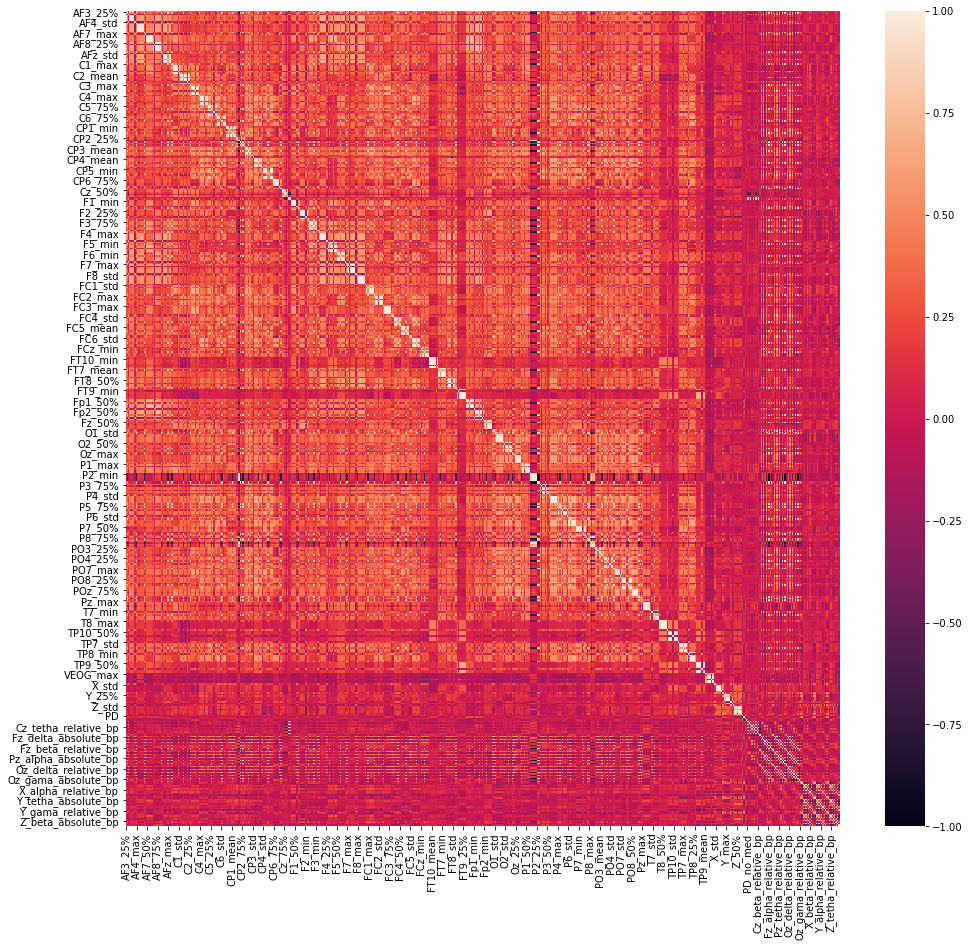

Sets with corr >=05 or < 1.0:



,,0
PD,PD_no_med,0.500000
med,PD,0.500000
CTL,PD_no_med,0.500000
med,CTL,0.500000
PD_no_med,med,0.500000
...,...,...
FT10_mean,FT10_50%,0.999992
Cz_delta_absolute_bp,Cz_alpha_absolute_bp,0.999994
TP9_mean,TP9_50%,0.999997
Cz_tetha_absolute_bp,Cz_alpha_absolute_bp,0.999998


Features with strong correlation with output column '['PD_no_med']'

Sets with corr >=0.5 or < 1.0:


,PD_no_med
PD,0.5
CTL,0.5
med,0.5



Top 50 or less: (total number of features: 543)


,PD_no_med
X_delta_relative_bp,0.379352
Y_delta_relative_bp,0.352597
X_alpha_relative_bp,0.324407
Z_tetha_relative_bp,0.289732
Z_alpha_relative_bp,0.277168
Y_tetha_relative_bp,0.264210
X_delta_absolute_bp,0.258869
X_tetha_relative_bp,0.249533
Z_delta_absolute_bp,0.233156
Y_delta_absolute_bp,0.230807


In [10]:
print("## Analyse correlation with all data available")
analyse_data_corr(dataset)


## Analyse correlation with filtered data (['X', 'Y', 'Z', 'Cz', 'Fz', 'Pz', 'Oz', 'PD_no_med', 'filename', 'PD', 'CTL', 'sex', 'med']):

filtered dataframe columns:
['Cz_50%' 'Cz_75%' 'Cz_mean' 'Cz_min' 'Cz_25%' 'Cz_std' 'Cz_max' 'Fz_50%'
 'Fz_max' 'Fz_min' 'Fz_mean' 'Fz_75%' 'Fz_25%' 'Fz_std' 'Oz_max' 'Oz_std'
 'Oz_25%' 'Oz_50%' 'Oz_mean' 'Oz_min' 'Oz_75%' 'Pz_max' 'Pz_std' 'Pz_mean'
 'Pz_50%' 'Pz_min' 'Pz_75%' 'Pz_25%' 'X_std' 'X_75%' 'X_mean' 'X_25%'
 'X_50%' 'X_min' 'X_max' 'Y_25%' 'Y_max' 'Y_mean' 'Y_75%' 'Y_50%' 'Y_std'
 'Y_min' 'Z_std' 'Z_75%' 'Z_50%' 'Z_min' 'Z_25%' 'Z_mean' 'Z_max'
 'filename' 'PD' 'CTL' 'sex' 'med' 'PD_no_med' 'Cz_delta_absolute_bp'
 'Cz_delta_relative_bp' 'Cz_tetha_absolute_bp' 'Cz_tetha_relative_bp'
 'Cz_alpha_absolute_bp' 'Cz_alpha_relative_bp' 'Cz_beta_absolute_bp'
 'Cz_beta_relative_bp' 'Cz_gama_absolute_bp' 'Cz_gama_relative_bp'
 'Fz_delta_absolute_bp' 'Fz_delta_relative_bp' 'Fz_tetha_absolute_bp'
 'Fz_tetha_relative_bp' 'Fz_alpha_absolute_bp' 'Fz_alp

,Cz_50%,Cz_75%,Cz_mean,Cz_min,Cz_25%,Cz_std,Cz_max,Fz_50%,Fz_max,Fz_min,...,Z_delta_absolute_bp,Z_delta_relative_bp,Z_tetha_absolute_bp,Z_tetha_relative_bp,Z_alpha_absolute_bp,Z_alpha_relative_bp,Z_beta_absolute_bp,Z_beta_relative_bp,Z_gama_absolute_bp,Z_gama_relative_bp
Cz_50%,1.000000,0.997574,0.768683,0.165749,0.995838,-0.008593,0.140419,0.494727,0.202580,0.462667,...,0.046204,-0.020762,0.018131,0.077385,0.018969,0.029636,0.019470,0.058193,0.022998,0.008305
Cz_75%,0.997574,1.000000,0.763909,0.157827,0.988319,-0.001564,0.149616,0.501371,0.217299,0.452638,...,0.064143,-0.022897,0.021570,0.072601,0.022561,0.025622,0.023590,0.059951,0.028033,0.005495
Cz_mean,0.768683,0.763909,1.000000,0.757191,0.772424,-0.645624,-0.479262,0.376801,0.161578,0.405062,...,0.043525,0.013248,0.022847,0.037622,0.023108,0.019325,0.023730,0.070664,0.030832,0.068606
Cz_min,0.165749,0.157827,0.757191,1.000000,0.178655,-0.986925,-0.893619,0.070137,0.008984,0.162626,...,0.003770,0.039873,0.017305,-0.015554,0.016360,0.001507,0.015353,0.040981,0.019088,0.096917
Cz_25%,0.995838,0.988319,0.772424,0.178655,1.000000,-0.020892,0.130006,0.480981,0.194225,0.475044,...,0.020132,-0.015172,0.014962,0.077026,0.016034,0.038879,0.016640,0.064230,0.020328,0.015163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z_alpha_relative_bp,0.029636,0.025622,0.019325,0.001507,0.038879,0.006565,0.007854,0.100200,0.025341,0.135654,...,-0.361422,-0.210517,-0.013222,0.365505,-0.011625,1.000000,-0.012715,0.475750,-0.038716,-0.387538
Z_beta_absolute_bp,0.019470,0.023590,0.023730,0.015353,0.016640,-0.011653,0.008472,0.129717,0.095626,0.133637,...,0.182011,-0.213814,0.992061,0.287909,0.996248,-0.012715,1.000000,-0.095912,0.965798,-0.202603
Z_beta_relative_bp,0.058193,0.059951,0.070664,0.040981,0.064230,-0.034297,0.067681,0.167789,0.293838,0.158495,...,-0.219897,0.002801,-0.158369,-0.359433,-0.140397,0.475750,-0.095912,1.000000,-0.013024,0.385439
Z_gama_absolute_bp,0.022998,0.028033,0.030832,0.019088,0.020328,-0.016830,0.043042,0.117318,0.188685,0.107087,...,0.341043,-0.129819,0.936106,0.225398,0.945475,-0.038716,0.965798,-0.013024,1.000000,-0.145040


describe of correlation row with output column '['PD_no_med']':


,count,mean,std,min,25%,50%,75%,max
PD_no_med,123.0,-0.023982,0.172749,-0.5,-0.097475,-0.042009,0.024835,1.0



correlation matrix heatmap:


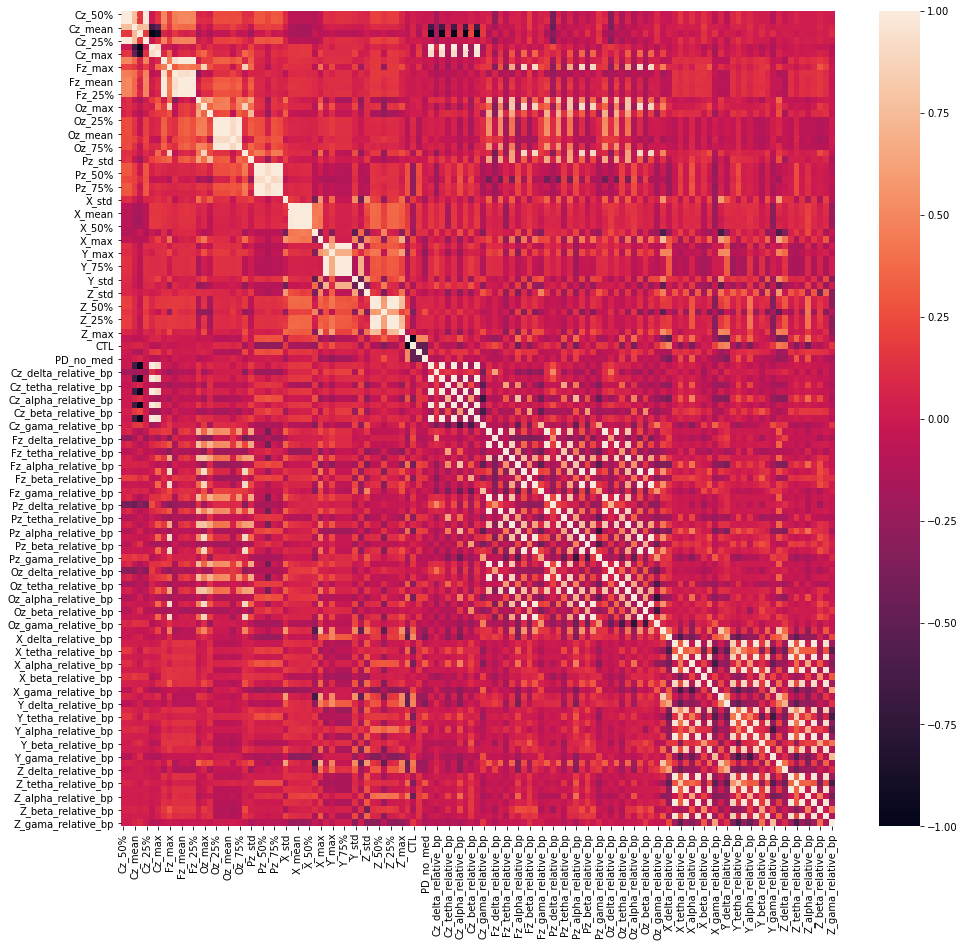

Sets with corr >=05 or < 1.0:



0
PD                   med                   0.500000
                     PD_no_med             0.500000
CTL                  PD_no_med             0.500000
PD_no_med            med                   0.500000
med                  PD_no_med             0.500000
...                                             ...
Pz_gama_absolute_bp  Fz_gama_absolute_bp   0.999944
Oz_delta_absolute_bp Pz_delta_absolute_bp  0.999982
Cz_delta_absolute_bp Cz_alpha_absolute_bp  0.999994
Cz_tetha_absolute_bp Cz_alpha_absolute_bp  0.999998
Cz_delta_absolute_bp Cz_tetha_absolute_bp  0.999998

[445 rows x 1 columns]

Features with strong correlation with output column '['PD_no_med']'

Sets with corr >=0.5 or < 1.0:


,PD_no_med
PD,0.5
CTL,0.5
med,0.5



Top 50 or less: (total number of features: 123)


,PD_no_med
X_delta_relative_bp,0.379352
Y_delta_relative_bp,0.352597
X_alpha_relative_bp,0.324407
Z_tetha_relative_bp,0.289732
Z_alpha_relative_bp,0.277168
Y_tetha_relative_bp,0.264210
X_delta_absolute_bp,0.258869
X_tetha_relative_bp,0.249533
Z_delta_absolute_bp,0.233156
Y_delta_absolute_bp,0.230807


In [11]:
dataset_filter1 = dataset.copy()
filter1by = ['X', 'Y', 'Z', 'Cz', 'Fz', 'Pz', 'Oz'] + col_y + col_meta
rm_cols = ['AFz', 'FCz', 'POz']
filtercols = [column for column in dataset.columns if any([substr in column for substr in filter1by])]
filtercols = [column for column in filtercols if not any([substr in column for substr in rm_cols])]
dataset_filter1 = dataset_filter1[filtercols]

col_features_filter1 = [column for column in dataset_filter1 if all([column != each for each in col_y + col_meta])]

print(f"\n## Analyse correlation with filtered data ({filter1by}):\n")
print("filtered dataframe columns:")
print(dataset_filter1.columns.values)
print("\nfiltered dataframe feature columns:")
print(col_features_filter1)

analyse_data_corr(dataset_filter1)

In [12]:
def split_train_test(df, col_features):
    # splitting training and test
    dt_train, dt_test = train_test_split(df[col_features + col_y], test_size=0.3, random_state=seed)

    print("dt_train")
    display(dt_train.describe().T)

    print("dt_test")
    display(dt_test.describe().T)
    return dt_train, dt_test

print('## split_train_test, dataset with all features')
dt_train, dt_test = split_train_test(dataset, col_features)
print('\n## split_train_test, dataset with filtered features')
dt_train_filter1, dt_test_filter1 = split_train_test(dataset_filter1, col_features_filter1)

## split_train_test, dataset with all features
dt_train


,count,mean,std,min,25%,50%,75%,max
AF3_25%,58.0,-8.688176e+03,1.031316e+04,-37037.792969,-1.340255e+04,-9.089868e+03,-3.041833e+03,2.082782e+04
AF3_max,58.0,-2.558140e+03,2.334718e+04,-33375.242188,-9.645117e+03,-4.788940e+03,4.375000e+01,1.542030e+05
AF3_std,58.0,1.097945e+03,8.595817e+02,68.264191,4.305962e+02,9.840516e+02,1.552606e+03,4.875831e+03
AF3_75%,58.0,-6.874977e+03,9.857557e+03,-35208.984375,-1.096810e+04,-7.150537e+03,-1.922034e+03,2.113667e+04
AF3_min,58.0,-1.000037e+04,1.037217e+04,-37601.855469,-1.589617e+04,-9.983130e+03,-4.256702e+03,2.032334e+04
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,58.0,2.236755e+08,1.147651e+09,2.445464,1.702277e+07,3.474965e+07,6.336425e+07,8.759770e+09
Z_beta_relative_bp,58.0,1.652797e-01,4.534026e-02,0.061983,1.386211e-01,1.634044e-01,1.846719e-01,2.937468e-01
Z_gama_absolute_bp,58.0,4.940349e+07,1.689309e+08,5.872192,8.162048e+06,1.414777e+07,2.523428e+07,1.237630e+09
Z_gama_relative_bp,58.0,1.912897e-01,8.917186e-02,0.034078,1.268811e-01,1.827741e-01,2.288467e-01,4.309246e-01


dt_test


,count,mean,std,min,25%,50%,75%,max
AF3_25%,26.0,-1.114143e+04,1.285734e+04,-4.666309e+04,-1.559510e+04,-1.011108e+04,-1.174744e+03,4.632788e+03
AF3_max,26.0,-7.250160e+03,1.548584e+04,-4.399585e+04,-1.090228e+04,-8.002686e+03,5.186646e+02,3.939262e+04
AF3_std,26.0,1.058546e+03,1.213166e+03,2.980638e+02,4.555252e+02,6.906060e+02,1.123328e+03,6.458902e+03
AF3_75%,26.0,-9.263014e+03,1.333183e+04,-4.577114e+04,-1.218552e+04,-9.393921e+03,-4.273346e+02,1.507705e+04
AF3_min,26.0,-1.256545e+04,1.239312e+04,-4.689975e+04,-1.736779e+04,-1.121545e+04,-3.909448e+03,3.657080e+03
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,26.0,6.852932e+07,1.217524e+08,4.964414e+06,2.099003e+07,3.126146e+07,5.560820e+07,6.342448e+08
Z_beta_relative_bp,26.0,1.581997e-01,4.893811e-02,9.227955e-02,1.193536e-01,1.453581e-01,1.913405e-01,2.724511e-01
Z_gama_absolute_bp,26.0,2.052805e+07,1.873110e+07,4.134150e+06,8.735926e+06,1.365188e+07,2.387029e+07,7.503627e+07
Z_gama_relative_bp,26.0,1.688252e-01,6.580472e-02,4.859029e-02,1.337434e-01,1.645682e-01,1.899821e-01,3.209003e-01



## split_train_test, dataset with filtered features
dt_train


,count,mean,std,min,25%,50%,75%,max
Cz_50%,58.0,2.443231e+03,7.165631e+03,-8972.802734,-2.139966e+03,1.558203e+03,5.493689e+03,3.348423e+04
Cz_75%,58.0,2.897200e+03,7.209639e+03,-8486.425781,-1.585327e+03,2.148193e+03,5.674829e+03,3.374279e+04
Cz_mean,58.0,1.456854e+03,1.050379e+04,-56010.124223,-2.112410e+03,1.541274e+03,5.365607e+03,3.340404e+04
Cz_min,58.0,-6.046683e+03,5.580744e+04,-420204.343750,-2.788696e+03,9.231201e+02,4.121521e+03,3.240283e+04
Cz_25%,58.0,1.990880e+03,7.137079e+03,-9441.943359,-2.371533e+03,1.346021e+03,5.155603e+03,3.291147e+04
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,58.0,2.236755e+08,1.147651e+09,2.445464,1.702277e+07,3.474965e+07,6.336425e+07,8.759770e+09
Z_beta_relative_bp,58.0,1.652797e-01,4.534026e-02,0.061983,1.386211e-01,1.634044e-01,1.846719e-01,2.937468e-01
Z_gama_absolute_bp,58.0,4.940349e+07,1.689309e+08,5.872192,8.162048e+06,1.414777e+07,2.523428e+07,1.237630e+09
Z_gama_relative_bp,58.0,1.912897e-01,8.917186e-02,0.034078,1.268811e-01,1.827741e-01,2.288467e-01,4.309246e-01


dt_test


,count,mean,std,min,25%,50%,75%,max
Cz_50%,26.0,8.418588e+02,8.162309e+03,-1.761738e+04,-1.749060e+03,1.984351e+03,4.981812e+03,1.832656e+04
Cz_75%,26.0,1.446139e+03,8.157126e+03,-1.681738e+04,-9.532104e+02,2.713062e+03,5.046545e+03,1.918691e+04
Cz_mean,26.0,7.445550e+02,8.077541e+03,-1.745899e+04,-1.623242e+03,2.020358e+03,4.345037e+03,1.830060e+04
Cz_min,26.0,-1.502180e+03,8.907733e+03,-2.030615e+04,-5.477124e+03,-8.764648e+01,3.254639e+03,1.621509e+04
Cz_25%,26.0,5.353910e+01,8.137617e+03,-1.808921e+04,-2.409009e+03,4.859375e+02,4.227747e+03,1.760967e+04
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,26.0,6.852932e+07,1.217524e+08,4.964414e+06,2.099003e+07,3.126146e+07,5.560820e+07,6.342448e+08
Z_beta_relative_bp,26.0,1.581997e-01,4.893811e-02,9.227955e-02,1.193536e-01,1.453581e-01,1.913405e-01,2.724511e-01
Z_gama_absolute_bp,26.0,2.052805e+07,1.873110e+07,4.134150e+06,8.735926e+06,1.365188e+07,2.387029e+07,7.503627e+07
Z_gama_relative_bp,26.0,1.688252e-01,6.580472e-02,4.859029e-02,1.337434e-01,1.645682e-01,1.899821e-01,3.209003e-01


In [13]:
def preprocess_inputs(dt_train, dt_test, col_features):
    scaler = StandardScaler()
    dt_train_scaled = dt_train.copy()
    dt_train_scaled[col_features] = scaler.fit_transform(dt_train[col_features])

    print("train_scaled")
    display(dt_train_scaled.describe().T)

    ## apply to test
    dt_test_scaled = dt_test.copy()
    dt_test_scaled[col_features] = scaler.transform(dt_test[col_features])

    print("test_scaled")
    display(dt_test_scaled.describe().T)

    # split features from labels
    X_dt_train_scaled = dt_train_scaled[col_features]
    Y_dt_train = dt_train_scaled[col_y]

    X_dt_test_scaled = dt_test_scaled[col_features]
    Y_dt_test = dt_test_scaled[col_y]
    
    return X_dt_train_scaled, Y_dt_train, X_dt_test_scaled, Y_dt_test

print('## preprocess inputs, center and normalize (dataset with all features)')
X_dt_train_scaled, Y_dt_train, X_dt_test_scaled, Y_dt_test = preprocess_inputs(dt_train, dt_test, col_features)

print('\n## preprocess inputs, center and normalize (dataset with filtered features)')
X_dt_filter1_train_scaled, Y_dt_filter1_train, X_dt_filter1_test_scaled, Y_dt_filter1_test = \
    preprocess_inputs(dt_train_filter1, dt_test_filter1, col_features_filter1)

## preprocess inputs, center and normalize (dataset with all features)
train_scaled


,count,mean,std,min,25%,50%,75%,max
AF3_25%,58.0,-5.359697e-17,1.008734,-2.772885,-0.461114,-0.039290,0.552271,2.886969
AF3_max,58.0,1.627051e-17,1.008734,-1.331478,-0.306199,-0.096384,0.112417,6.772992
AF3_std,58.0,4.785444e-17,1.008734,-1.208348,-0.783145,-0.133655,0.533553,4.433414
AF3_75%,58.0,9.188053e-17,1.008734,-2.899448,-0.418854,-0.028198,0.506840,2.866460
AF3_min,58.0,5.359697e-17,1.008734,-2.684351,-0.573389,0.001677,0.558594,2.949098
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,58.0,5.742533e-18,1.008734,-0.196601,-0.181638,-0.166057,-0.140906,7.502843
Z_beta_relative_bp,58.0,2.718132e-16,1.008734,-2.298150,-0.593103,-0.041723,0.431439,2.858146
Z_gama_absolute_bp,58.0,-5.694678e-17,1.008734,-0.295002,-0.246264,-0.210522,-0.144321,7.095232
Z_gama_relative_bp,58.0,3.445520e-17,1.008734,-1.778420,-0.728606,-0.096330,0.424854,2.710809


test_scaled


,count,mean,std,min,25%,50%,75%,max
AF3_25%,26.0,-0.239954,1.257581,-3.714338,-0.675569,-0.139175,0.734891,1.302928
AF3_max,26.0,-0.202722,0.669078,-1.790349,-0.360515,-0.235236,0.132936,1.812516
AF3_std,26.0,-0.046235,1.423671,-0.938674,-0.753890,-0.478019,0.029787,6.291175
AF3_75%,26.0,-0.244370,1.364260,-3.980284,-0.543433,-0.257766,0.659794,2.246373
AF3_min,26.0,-0.249464,1.205279,-3.588607,-0.716509,-0.118171,0.592366,1.328240
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,26.0,-0.136366,0.107015,-0.192237,-0.178151,-0.169123,-0.147724,0.360872
Z_beta_relative_bp,26.0,-0.157517,1.088779,-1.624114,-1.021769,-0.443219,0.579802,2.384357
Z_gama_absolute_bp,26.0,-0.172423,0.111849,-0.270316,-0.242837,-0.213483,-0.152466,0.153061
Z_gama_relative_bp,26.0,-0.254124,0.744399,-1.614250,-0.650977,-0.302280,-0.014791,1.466186



## preprocess inputs, center and normalize (dataset with filtered features)
train_scaled


,count,mean,std,min,25%,50%,75%,max
Cz_50%,58.0,-5.742533e-18,1.008734,-1.607080,-0.645194,-0.124589,0.429425,4.369762
Cz_75%,58.0,-4.306900e-18,1.008734,-1.592735,-0.627171,-0.104797,0.388631,4.315748
Cz_mean,58.0,1.387779e-17,1.008734,-5.518853,-0.342775,0.008107,0.375378,3.068055
Cz_min,58.0,-9.570888e-19,1.008734,-7.486006,0.058889,0.125981,0.183793,0.694985
Cz_25%,58.0,-2.297013e-17,1.008734,-1.615882,-0.616571,-0.091143,0.447293,4.370226
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,58.0,5.742533e-18,1.008734,-0.196601,-0.181638,-0.166057,-0.140906,7.502843
Z_beta_relative_bp,58.0,2.718132e-16,1.008734,-2.298150,-0.593103,-0.041723,0.431439,2.858146
Z_gama_absolute_bp,58.0,-5.694678e-17,1.008734,-0.295002,-0.246264,-0.210522,-0.144321,7.095232
Z_gama_relative_bp,58.0,3.445520e-17,1.008734,-1.778420,-0.728606,-0.096330,0.424854,2.710809


test_scaled


,count,mean,std,min,25%,50%,75%,max
Cz_50%,26.0,-0.225431,1.149040,-2.824011,-0.590165,-0.064598,0.357366,2.235958
Cz_75%,26.0,-0.203025,1.141301,-2.758358,-0.538729,-0.025764,0.300725,2.279169
Cz_mean,26.0,-0.068406,0.775728,-1.816587,-0.295798,0.054116,0.277367,1.617593
Cz_min,26.0,0.082143,0.161010,-0.257744,0.010295,0.107711,0.168124,0.402387
Cz_25%,26.0,-0.273818,1.150147,-2.838061,-0.621867,-0.212704,0.316152,2.207514
...,...,...,...,...,...,...,...,...
Z_beta_absolute_bp,26.0,-0.136366,0.107015,-0.192237,-0.178151,-0.169123,-0.147724,0.360872
Z_beta_relative_bp,26.0,-0.157517,1.088779,-1.624114,-1.021769,-0.443219,0.579802,2.384357
Z_gama_absolute_bp,26.0,-0.172423,0.111849,-0.270316,-0.242837,-0.213483,-0.152466,0.153061
Z_gama_relative_bp,26.0,-0.254124,0.744399,-1.614250,-0.650977,-0.302280,-0.014791,1.466186


# Experiments models training

In [14]:
%%time
regr = LogisticRegression()

scoring_metric='f1'

def run_experiments(expr_params):
    results_dict = []
    
    for i, params in enumerate(expr_params):
        print(f'\n# Experiment ({i+1}/{len(expr_params)}):')
        display(pd.DataFrame.from_records(expr_params).iloc[i])

        if params['search_type'] == 'grid':
            clf = GridSearchCV(params['model'], param_grid=params['param_grid'],
                               cv=KFold(n_folds, shuffle=True, random_state=seed),
                               scoring=scoring_metric, n_jobs=-1)
        else:
            clf = RandomizedSearchCV(params['model'], params['param_grid'],
                                     cv=KFold(n_folds, shuffle=True, random_state=seed),
                                     scoring=scoring_metric, n_jobs=-1)
        
        if params['expr_dataset'] == 'dataset_full':
            X_train = X_dt_train_scaled
            Y_train = Y_dt_train
            X_test  = X_dt_test_scaled
            Y_test  = Y_dt_test
        elif params['expr_dataset'] == 'dataset_filtered_features':
            X_train = X_dt_filter1_train_scaled
            Y_train = Y_dt_filter1_train
            X_test  = X_dt_filter1_test_scaled
            Y_test  = Y_dt_filter1_test
        else:
            raise f'Invalid dataset as experiment parameter ({params["expr_dataset"]})'
        
        clf.fit(X_train, Y_train.values.ravel())

        f1_kfold = clf.best_score_
        f1_test = clf.score(X_test, Y_test.values.ravel())

        pred_train = clf.best_estimator_.predict(X_train)
        pred_test = clf.best_estimator_.predict(X_test)
        
        acc_train = accuracy_score(Y_train, pred_train)
        acc_test = accuracy_score(Y_test, pred_test)

        bacc_train = balanced_accuracy_score(Y_train, pred_train)
        bacc_test = balanced_accuracy_score(Y_test, pred_test)
        
        precision_train = precision_score(Y_train, pred_train)
        precision_test = precision_score(Y_test, pred_test)
        
        recall_train = recall_score(Y_train, pred_train)
        recall_test = recall_score(Y_test, pred_test)
        
        roc_auc_train = roc_auc_score(Y_train, pred_train)
        roc_auc_test = roc_auc_score(Y_test, pred_test)
        
        cohen_kappa_train = cohen_kappa_score(Y_train, pred_train)
        cohen_kappa_test = cohen_kappa_score(Y_test, pred_test)

        results_entry = {
            'model': params['model_name'],
            'dataset': params["expr_dataset"],
            'f1_train': f1_kfold,
            'f1_test': f1_test,
            'acc_train': acc_train,
            'acc_test': acc_test,
            'balanced_acc_train': bacc_train,
            'balanced_acc_test': bacc_test,
            'precision_train': precision_train,
            'precision_test': precision_test,
            'recall_train': recall_train,
            'recall_test': recall_test,
            'roc_auc_train': roc_auc_train,
            'roc_auc_test': roc_auc_test,
            'cohen_kappa_train': cohen_kappa_train,
            'cohen_kappa_test': cohen_kappa_test,
            'param_grid': params['param_grid'],
            'best_params': clf.best_params_,
        }
        display(pd.DataFrame.from_records([results_entry]))
        results_dict.append(results_entry)
    return pd.DataFrame.from_records(results_dict)

results = run_experiments(expr_params)
results


# Experiment (1/14):


model_name         LogisticRegression
model            LogisticRegression()
param_grid                         {}
search_type                      grid
expr_dataset             dataset_full
search_n_iter                     NaN
Name: 0, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,LogisticRegression,dataset_full,0.361587,0.545455,1.0,0.615385,1.0,0.691729,1.0,0.4,1.0,0.857143,1.0,0.691729,1.0,0.281768,{},{}



# Experiment (2/14):


model_name              LogisticRegression
model                 LogisticRegression()
param_grid                              {}
search_type                           grid
expr_dataset     dataset_filtered_features
search_n_iter                          NaN
Name: 1, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,LogisticRegression,dataset_filtered_features,0.197172,0.555556,0.965517,0.692308,0.962677,0.699248,0.952381,0.454545,0.952381,0.714286,0.962677,0.699248,0.925354,0.33758,{},{}



# Experiment (3/14):


model_name                                   LogisticRegression_L2
model                                         LogisticRegression()
param_grid       {'penalty': ['l2'], 'C': [0.03125, 0.041468603...
search_type                                                   grid
expr_dataset                                          dataset_full
search_n_iter                                                  NaN
Name: 2, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,LogisticRegression_L2,dataset_full,0.449878,0.5,1.0,0.538462,1.0,0.639098,1.0,0.352941,1.0,0.857143,1.0,0.639098,1.0,0.19171,"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...","{'C': 4522.350648007934, 'penalty': 'l2'}"



# Experiment (4/14):


model_name                                   LogisticRegression_L2
model                                         LogisticRegression()
param_grid       {'penalty': ['l2'], 'C': [0.03125, 0.041468603...
search_type                                                   grid
expr_dataset                             dataset_filtered_features
search_n_iter                                                  NaN
Name: 3, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,LogisticRegression_L2,dataset_filtered_features,0.263203,0.625,0.862069,0.769231,0.81982,0.75188,0.933333,0.555556,0.666667,0.714286,0.81982,0.75188,0.681756,0.462069,"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...","{'C': 0.09690084531141929, 'penalty': 'l2'}"



# Experiment (5/14):


model_name                                       SVM kernel linear
model                         SVC(kernel='linear', max_iter=10000)
param_grid       {'C': [0.03125, 0.04146860325085487, 0.0550286...
search_type                                                   rand
expr_dataset                                          dataset_full
search_n_iter                                                 50.0
Name: 4, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,SVM kernel linear,dataset_full,0.301587,0.5,1.0,0.538462,1.0,0.639098,1.0,0.352941,1.0,0.857143,1.0,0.639098,1.0,0.19171,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.04146860325085487, 'C': 4522.35064..."



# Experiment (6/14):


model_name                                       SVM kernel linear
model                         SVC(kernel='linear', max_iter=10000)
param_grid       {'C': [0.03125, 0.04146860325085487, 0.0550286...
search_type                                                   rand
expr_dataset                             dataset_filtered_features
search_n_iter                                                 50.0
Name: 5, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,SVM kernel linear,dataset_filtered_features,0.266667,0.5,0.827586,0.692308,0.772201,0.654135,0.923077,0.444444,0.571429,0.571429,0.772201,0.654135,0.593268,0.282759,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.007594568292413517, 'C': 0.03125}"



# Experiment (7/14):


model_name                                          SVM kernel rbf
model                                          SVC(max_iter=10000)
param_grid       {'C': [0.03125, 0.04146860325085487, 0.0550286...
search_type                                                   rand
expr_dataset                                          dataset_full
search_n_iter                                                 50.0
Name: 6, dtype: object

/c/Users/languor/workspace/conda/envs/imgprocessing-t4/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,SVM kernel rbf,dataset_full,0.0,0.0,1.0,0.730769,1.0,0.5,1.0,0.0,1.0,0.0,1.0,0.5,1.0,0.0,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.05823212932104882, 'C': 151.681145..."



# Experiment (8/14):


model_name                                          SVM kernel rbf
model                                          SVC(max_iter=10000)
param_grid       {'C': [0.03125, 0.04146860325085487, 0.0550286...
search_type                                                   rand
expr_dataset                             dataset_filtered_features
search_n_iter                                                 50.0
Name: 7, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,SVM kernel rbf,dataset_filtered_features,0.157143,0.153846,1.0,0.576923,1.0,0.43985,1.0,0.166667,1.0,0.142857,1.0,0.43985,1.0,-0.125984,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.02102969050988057, 'C': 267.097838..."



# Experiment (9/14):


model_name                                                     KNN
model                                       KNeighborsClassifier()
param_grid       {'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...
search_type                                                   rand
expr_dataset                                          dataset_full
search_n_iter                                                 40.0
Name: 8, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,KNN,dataset_full,0.273333,0.285714,0.689655,0.615385,0.602317,0.511278,0.666667,0.285714,0.285714,0.285714,0.602317,0.511278,0.23348,0.022556,"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",{'n_neighbors': 6}



# Experiment (10/14):


model_name                                                     KNN
model                                       KNeighborsClassifier()
param_grid       {'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...
search_type                                                   rand
expr_dataset                             dataset_filtered_features
search_n_iter                                                 40.0
Name: 9, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,KNN,dataset_filtered_features,0.3,0.533333,0.637931,0.730769,0.530888,0.680451,0.5,0.5,0.142857,0.571429,0.530888,0.680451,0.073059,0.345324,"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",{'n_neighbors': 25}



# Experiment (11/14):


model_name                                           Decision Tree
model                                     DecisionTreeClassifier()
param_grid       {'ccp_alpha': [0.0, 0.003184430739849202, 0.01...
search_type                                                   rand
expr_dataset                                          dataset_full
search_n_iter                                                 50.0
Name: 10, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,Decision Tree,dataset_full,0.363377,0.235294,0.982759,0.5,0.97619,0.432331,1.0,0.2,0.952381,0.285714,0.97619,0.432331,0.962289,-0.119205,"{'ccp_alpha': [0.0, 0.003184430739849202, 0.01...",{'ccp_alpha': 0.03982181317270822}



# Experiment (12/14):


model_name                                           Decision Tree
model                                     DecisionTreeClassifier()
param_grid       {'ccp_alpha': [0.0, 0.003184430739849202, 0.01...
search_type                                                   rand
expr_dataset                             dataset_filtered_features
search_n_iter                                                 50.0
Name: 11, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,Decision Tree,dataset_filtered_features,0.549408,0.6,1.0,0.692308,1.0,0.744361,1.0,0.461538,1.0,0.857143,1.0,0.744361,1.0,0.384615,"{'ccp_alpha': [0.0, 0.003184430739849202, 0.01...",{'ccp_alpha': 0.0264529288879376}



# Experiment (13/14):


model_name                                           Random Forest
model                                     RandomForestClassifier()
param_grid       {'n_estimators': [10, 100, 1000], 'max_feature...
search_type                                                   grid
expr_dataset                                          dataset_full
search_n_iter                                                  NaN
Name: 12, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,Random Forest,dataset_full,0.281587,0.0,1.0,0.576923,1.0,0.394737,1.0,0.0,1.0,0.0,1.0,0.394737,1.0,-0.243478,"{'n_estimators': [10, 100, 1000], 'max_feature...","{'max_features': 22, 'n_estimators': 100}"



# Experiment (14/14):


model_name                                           Random Forest
model                                     RandomForestClassifier()
param_grid       {'n_estimators': [10, 100, 1000], 'max_feature...
search_type                                                   grid
expr_dataset                             dataset_filtered_features
search_n_iter                                                  NaN
Name: 13, dtype: object

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,Random Forest,dataset_filtered_features,0.305397,0.5,1.0,0.692308,1.0,0.654135,1.0,0.444444,1.0,0.571429,1.0,0.654135,1.0,0.282759,"{'n_estimators': [10, 100, 1000], 'max_feature...","{'max_features': 22, 'n_estimators': 100}"


CPU times: user 6.25 s, sys: 396 ms, total: 6.64 s
Wall time: 37.7 s


,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
0,LogisticRegression,dataset_full,0.361587,0.545455,1.000000,0.615385,1.000000,0.691729,1.000000,0.400000,1.000000,0.857143,1.000000,0.691729,1.000000,0.281768,{},{}
1,LogisticRegression,dataset_filtered_features,0.197172,0.555556,0.965517,0.692308,0.962677,0.699248,0.952381,0.454545,0.952381,0.714286,0.962677,0.699248,0.925354,0.337580,{},{}
2,LogisticRegression_L2,dataset_full,0.449878,0.500000,1.000000,0.538462,1.000000,0.639098,1.000000,0.352941,1.000000,0.857143,1.000000,0.639098,1.000000,0.191710,"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...","{'C': 4522.350648007934, 'penalty': 'l2'}"
3,LogisticRegression_L2,dataset_filtered_features,0.263203,0.625000,0.862069,0.769231,0.819820,0.751880,0.933333,0.555556,0.666667,0.714286,0.819820,0.751880,0.681756,0.462069,"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...","{'C': 0.09690084531141929, 'penalty': 'l2'}"
4,SVM kernel linear,dataset_full,0.301587,0.500000,1.000000,0.538462,1.000000,0.639098,1.000000,0.352941,1.000000,0.857143,1.000000,0.639098,1.000000,0.191710,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.04146860325085487, 'C': 4522.35064..."
5,SVM kernel linear,dataset_filtered_features,0.266667,0.500000,0.827586,0.692308,0.772201,0.654135,0.923077,0.444444,0.571429,0.571429,0.772201,0.654135,0.593268,0.282759,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.007594568292413517, 'C': 0.03125}"
6,SVM kernel rbf,dataset_full,0.000000,0.000000,1.000000,0.730769,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000,1.000000,0.000000,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.05823212932104882, 'C': 151.681145..."
7,SVM kernel rbf,dataset_filtered_features,0.157143,0.153846,1.000000,0.576923,1.000000,0.439850,1.000000,0.166667,1.000000,0.142857,1.000000,0.439850,1.000000,-0.125984,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.02102969050988057, 'C': 267.097838..."
8,KNN,dataset_full,0.273333,0.285714,0.689655,0.615385,0.602317,0.511278,0.666667,0.285714,0.285714,0.285714,0.602317,0.511278,0.233480,0.022556,"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",{'n_neighbors': 6}
9,KNN,dataset_filtered_features,0.300000,0.533333,0.637931,0.730769,0.530888,0.680451,0.500000,0.500000,0.142857,0.571429,0.530888,0.680451,0.073059,0.345324,"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",{'n_neighbors': 25}


In [15]:
results.sort_values(by=['roc_auc_test'], ascending=False)

,model,dataset,f1_train,f1_test,acc_train,acc_test,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,cohen_kappa_train,cohen_kappa_test,param_grid,best_params
3,LogisticRegression_L2,dataset_filtered_features,0.263203,0.625000,0.862069,0.769231,0.819820,0.751880,0.933333,0.555556,0.666667,0.714286,0.819820,0.751880,0.681756,0.462069,"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...","{'C': 0.09690084531141929, 'penalty': 'l2'}"
11,Decision Tree,dataset_filtered_features,0.549408,0.600000,1.000000,0.692308,1.000000,0.744361,1.000000,0.461538,1.000000,0.857143,1.000000,0.744361,1.000000,0.384615,"{'ccp_alpha': [0.0, 0.003184430739849202, 0.01...",{'ccp_alpha': 0.0264529288879376}
1,LogisticRegression,dataset_filtered_features,0.197172,0.555556,0.965517,0.692308,0.962677,0.699248,0.952381,0.454545,0.952381,0.714286,0.962677,0.699248,0.925354,0.337580,{},{}
0,LogisticRegression,dataset_full,0.361587,0.545455,1.000000,0.615385,1.000000,0.691729,1.000000,0.400000,1.000000,0.857143,1.000000,0.691729,1.000000,0.281768,{},{}
9,KNN,dataset_filtered_features,0.300000,0.533333,0.637931,0.730769,0.530888,0.680451,0.500000,0.500000,0.142857,0.571429,0.530888,0.680451,0.073059,0.345324,"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",{'n_neighbors': 25}
5,SVM kernel linear,dataset_filtered_features,0.266667,0.500000,0.827586,0.692308,0.772201,0.654135,0.923077,0.444444,0.571429,0.571429,0.772201,0.654135,0.593268,0.282759,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.007594568292413517, 'C': 0.03125}"
13,Random Forest,dataset_filtered_features,0.305397,0.500000,1.000000,0.692308,1.000000,0.654135,1.000000,0.444444,1.000000,0.571429,1.000000,0.654135,1.000000,0.282759,"{'n_estimators': [10, 100, 1000], 'max_feature...","{'max_features': 22, 'n_estimators': 100}"
2,LogisticRegression_L2,dataset_full,0.449878,0.500000,1.000000,0.538462,1.000000,0.639098,1.000000,0.352941,1.000000,0.857143,1.000000,0.639098,1.000000,0.191710,"{'penalty': ['l2'], 'C': [0.03125, 0.041468603...","{'C': 4522.350648007934, 'penalty': 'l2'}"
4,SVM kernel linear,dataset_full,0.301587,0.500000,1.000000,0.538462,1.000000,0.639098,1.000000,0.352941,1.000000,0.857143,1.000000,0.639098,1.000000,0.191710,"{'C': [0.03125, 0.04146860325085487, 0.0550286...","{'gamma': 0.04146860325085487, 'C': 4522.35064..."
8,KNN,dataset_full,0.273333,0.285714,0.689655,0.615385,0.602317,0.511278,0.666667,0.285714,0.285714,0.285714,0.602317,0.511278,0.233480,0.022556,"{'n_neighbors': [12, 38, 21, 16, 7, 27, 22, 38...",{'n_neighbors': 6}


In [16]:
results.sort_values(by=['roc_auc_test'], ascending=False).T

,3,11,1,0,9,5,13,2,4,8,6,7,10,12
model,LogisticRegression_L2,Decision Tree,LogisticRegression,LogisticRegression,KNN,SVM kernel linear,Random Forest,LogisticRegression_L2,SVM kernel linear,KNN,SVM kernel rbf,SVM kernel rbf,Decision Tree,Random Forest
dataset,dataset_filtered_features,dataset_filtered_features,dataset_filtered_features,dataset_full,dataset_filtered_features,dataset_filtered_features,dataset_filtered_features,dataset_full,dataset_full,dataset_full,dataset_full,dataset_filtered_features,dataset_full,dataset_full
f1_train,0.263203,0.549408,0.197172,0.361587,0.3,0.266667,0.305397,0.449878,0.301587,0.273333,0.0,0.157143,0.363377,0.281587
f1_test,0.625,0.6,0.555556,0.545455,0.533333,0.5,0.5,0.5,0.5,0.285714,0.0,0.153846,0.235294,0.0
acc_train,0.862069,1.0,0.965517,1.0,0.637931,0.827586,1.0,1.0,1.0,0.689655,1.0,1.0,0.982759,1.0
acc_test,0.769231,0.692308,0.692308,0.615385,0.730769,0.692308,0.692308,0.538462,0.538462,0.615385,0.730769,0.576923,0.5,0.576923
balanced_acc_train,0.81982,1.0,0.962677,1.0,0.530888,0.772201,1.0,1.0,1.0,0.602317,1.0,1.0,0.97619,1.0
balanced_acc_test,0.75188,0.744361,0.699248,0.691729,0.680451,0.654135,0.654135,0.639098,0.639098,0.511278,0.5,0.43985,0.432331,0.394737
precision_train,0.933333,1.0,0.952381,1.0,0.5,0.923077,1.0,1.0,1.0,0.666667,1.0,1.0,1.0,1.0
precision_test,0.555556,0.461538,0.454545,0.4,0.5,0.444444,0.444444,0.352941,0.352941,0.285714,0.0,0.166667,0.2,0.0


In [17]:
results.sort_values(by=['roc_auc_test'], ascending=False).to_csv('results_ordered_roc_auc_test.csv')
results.sort_values(by=['roc_auc_test'], ascending=False).T.to_csv('results_ordered_roc_auc_test_transposed.csv')